BearingX_Y 폴더는 하나의 베어링에 대한 전체 수명 주기 데이터
각 .csv 파일은 0.1초 간격으로 측정한 데이터 (acc_00001.csv는 Bearing1_1의 첫 번째 측정값, acc_00002.csv는 두 번째 측정값...)
하나의 .csv에는 진동 센서 3축(혹은 2축)의 시간축 샘플
Bearing1_1 폴더는 고장나기 전까지 계속 측정된 시계열 시퀀스 모음
전체 파일 수가 곧 그 베어링의 수명 길이 (예: 총 500개 → 수명 500단계)

 베어링이 정상 상태에서부터 점진적으로 열화되어 최종적으로 고장에 도달할 때까지 데이터를 지속적으로 수집하는 방식
 각 CSV 파일은 특정 시점(예: 10초 간격으로 샘플링)에서 0.1초 동안 측정된 원시 진동 신호 데이터를 담고 있습니다.

센서 데이터 CSV 파일의 컬럼 구성 (진동 데이터 기준)
열 번호	설명
1	Hour (시)
2	Minute (분)
3	Second (초)
4	Micro-second (마이크로초)
5	Horizontal acceleration (수평 방향 가속도)
6	Vertical acceleration (수직 방향 가속도)
두 센서는 베어링 외부에 **서로 직각 방향(90°)**으로 배치되어 있고, 베어링의 외륜(race)에 **방사형(radial)**으로 부착되어 있습니다
샘플링 주파수는 25.6 kHz, 측정 구간은 매 10초마다 0.1초씩 측정된다는 특징이 있습니다.

MAX_RUL = 50으로 설정하면, 모델이 변화가 적은 초기 데이터를 학습하는 데 시간을 낭비하지 않고, 
고장과 직접적으로 관련된 민감한 패턴과 이상 징후를 학습하는 데 집중할 수 있게 됩니다.

과적합 방지: RUL이 큰 초기 구간은 데이터의 변화가 적어 패턴이 단순하여 모델이 여기에 과적합될 위험이 있습니다.
중요한 고장 징후를 놓칠 수 있죠. MAX_RUL을 설정하면 이러한 초기, 상대적으로 의미 없는 데이터에 대한 과도한 학습을 방지하고, 
실제 고장 예측에 필요한 핵심적인 특징들을 더 효과적으로 추출하도록 유도합니다.

성능 향상: 많은 선행 연구에서 이와 같은 RUL 상한선(Capping) 기법이 딥러닝 기반 RUL 예측 모델의 성능을 향상시키는 데 기여함을 보여줍니다.

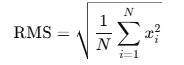

In [ ]:
#csv 형태 파악
import pandas as pd

# CSV 불러오기
df = pd.read_csv(r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1\acc_00001.csv", header=None)

# 헤더 지정
df.columns = ["Hour", "Minute", "Second", "Micro-second", "Horizontal Accel.", "Vertical Accel."]

from IPython.display import display
display(df.head())


,Hour,Minute,Second,Micro-second,Horizontal Accel.,Vertical Accel.
0,9,39,39,65664.0,0.552,-0.146
1,9,39,39,65703.0,0.501,-0.480
2,9,39,39,65742.0,0.138,0.435
3,9,39,39,65781.0,-0.423,0.240
4,9,39,39,65820.0,-0.802,0.020


# EDA

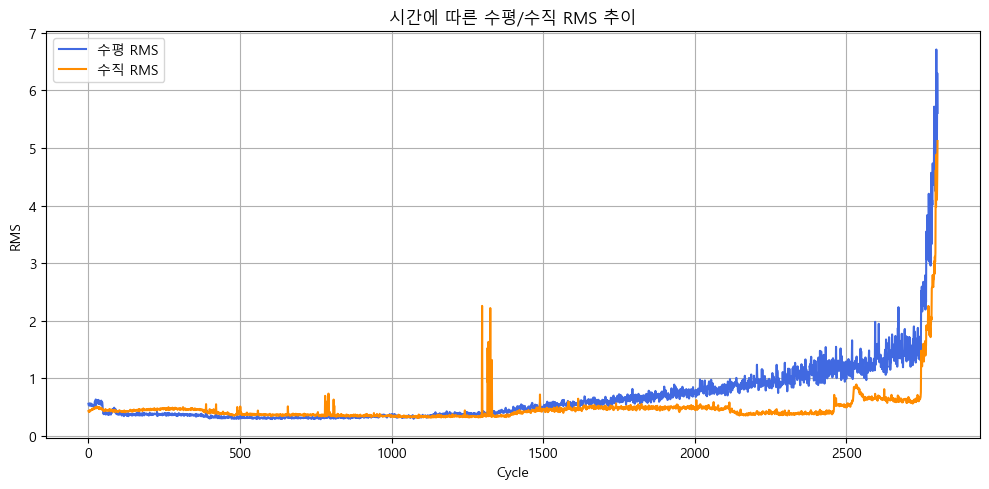

In [ ]:
# RMS 변화 시각화
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 설정 ---
folder_path = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 불러오기 ---
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]

# --- RMS 계산 (수평: col 4, 수직: col 5) ---
rms_horizontal = [np.sqrt((df.iloc[:, 4] ** 2).mean()) for df in data_list]
rms_vertical   = [np.sqrt((df.iloc[:, 5] ** 2).mean()) for df in data_list]

# --- 시각화 ---
plt.figure(figsize=(10, 5))
plt.plot(rms_horizontal, label='수평 RMS', color='royalblue')
plt.plot(rms_vertical, label='수직 RMS', color='darkorange')
plt.xlabel('Cycle')
plt.ylabel('RMS')
plt.title('시간에 따른 수평/수직 RMS 추이')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

초반 (왼쪽): 수평/수직 RMS 모두 안정적 → 정상 상태
중후반 (중간 이후): RMS가 서서히 증가 → 열화 진행
끝부분 (오른쪽): 급격한 상승 → 고장 직전 또는 고장
진동 세기의 추세가 고장 시점과 맞물려 증가한다

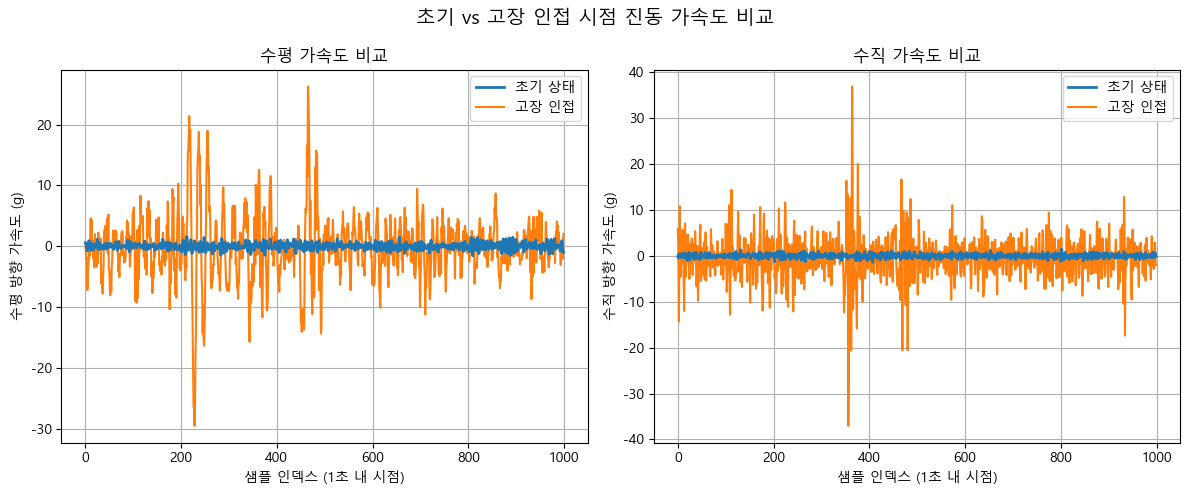

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 공통 컬럼명 정의
columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal accel.', 'Vertical accel.']

# --- 초기 시점 --- 
acc_early = pd.read_csv(
    r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1\acc_00001.csv", 
    header=None, names=columns)

# --- 고장 인접 시점 --- 
acc_late = pd.read_csv(
    r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1\acc_02803.csv", 
    header=None, names=columns)

# 시각화
plt.figure(figsize=(12, 5))

# 1. 수평 가속도 비교
plt.subplot(1, 2, 1)
plt.plot(acc_early['Horizontal accel.'][:1000], label='초기 상태', linewidth=2, zorder=3)
plt.plot(acc_late['Horizontal accel.'][:1000], label='고장 인접', zorder=2)
plt.title('수평 가속도 비교')
plt.xlabel('샘플 인덱스 (1초 내 시점)')
plt.ylabel('수평 방향 가속도 (g)')
plt.legend()
plt.grid(True)

# 2. 수직 가속도 비교
plt.subplot(1, 2, 2)
plt.plot(acc_early['Vertical accel.'][:1000], label='초기 상태', linewidth=2, zorder=3)
plt.plot(acc_late['Vertical accel.'][:1000], label='고장 인접', zorder=2)
plt.title('수직 가속도 비교')
plt.xlabel('샘플 인덱스 (1초 내 시점)')
plt.ylabel('수직 방향 가속도 (g)')
plt.legend()
plt.grid(True)

# 전체 제목
plt.suptitle('초기 vs 고장 인접 시점 진동 가속도 비교', fontsize=14)
plt.tight_layout()
plt.show()

초기 상태는 수평/수직 모두 진동이 작고 안정적임

고장 인접 시점에서는 두 방향 모두 진폭이 커지고 불규칙한 스파이크가 발생
→ 베어링 열화로 인해 진동 신호가 뚜렷하게 변형됨

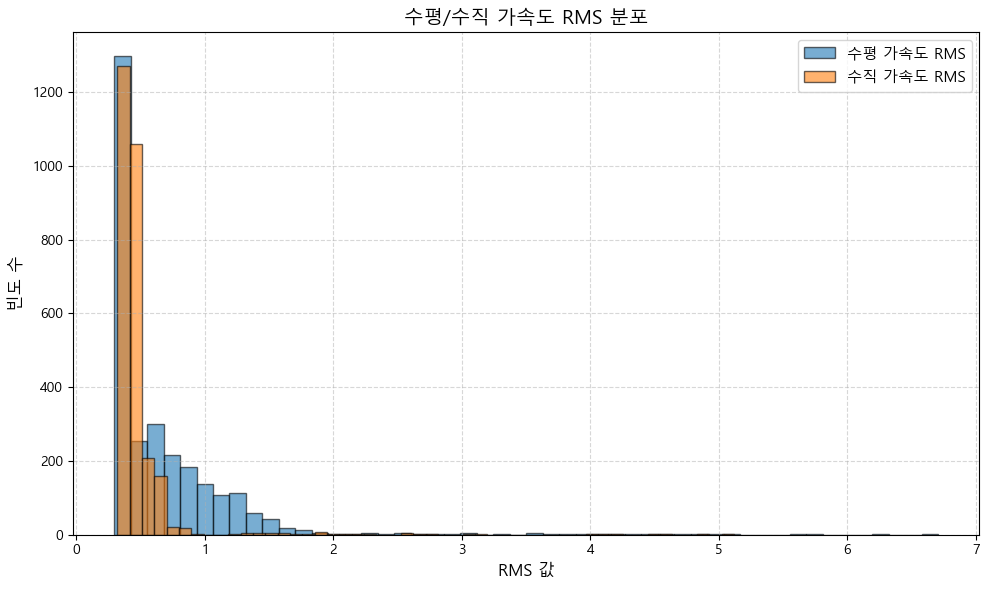

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# 데이터 폴더 경로
data_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])

# 컬럼명
columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal accel.', 'Vertical accel.']

# RMS 저장 리스트
rms_horizontal = []
rms_vertical = []

# 모든 CSV 파일에 대해 RMS 계산
for file in file_list:
    df = pd.read_csv(os.path.join(data_dir, file), header=None, names=columns)
    rms_h = np.sqrt(np.mean(df['Horizontal accel.']**2))
    rms_v = np.sqrt(np.mean(df['Vertical accel.']**2))
    rms_horizontal.append(rms_h)
    rms_vertical.append(rms_v)
plt.figure(figsize=(10, 6))

# 히스토그램
plt.hist(rms_horizontal, bins=50, alpha=0.6, label='수평 가속도 RMS',
         color='tab:blue', edgecolor='black')
plt.hist(rms_vertical, bins=50, alpha=0.6, label='수직 가속도 RMS',
         color='tab:orange', edgecolor='black')

# 로그 스케일 (선택 사항)
# plt.yscale('log')  # 값 분포가 너무 skewed되어 있으면 사용

# 라벨 및 제목
plt.xlabel('RMS 값', fontsize=12)
plt.ylabel('빈도 수', fontsize=12)
plt.title('수평/수직 가속도 RMS 분포', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

수평 vs 수직 중 어느 방향이 더 고장에 민감한가? 판단 가능
1. 수평/수직 진동의 RMS 분포 차이
    - 수평 가속도 RMS(파란색)**는 상대적으로 더 넓게 퍼져 있음 → 고장 진행 시 진폭이 더 불안정하게 커질 수 있음

    - 수직 가속도 RMS(주황색)**는 대부분이 0~1 사이에 몰려 있음 → 고장 징후가 수평보다 덜 민감하게 나타날 수 있음
2. 양 축 모두 대부분의 RMS가 낮음 (0~1 사이)
    - 대부분의 시간 동안 베어링이 정상 상태임을 의미

    - 고장이 임박한 일부 구간에서만 RMS가 급상승함 (→ 오른쪽 꼬리 부분=고장 신호)

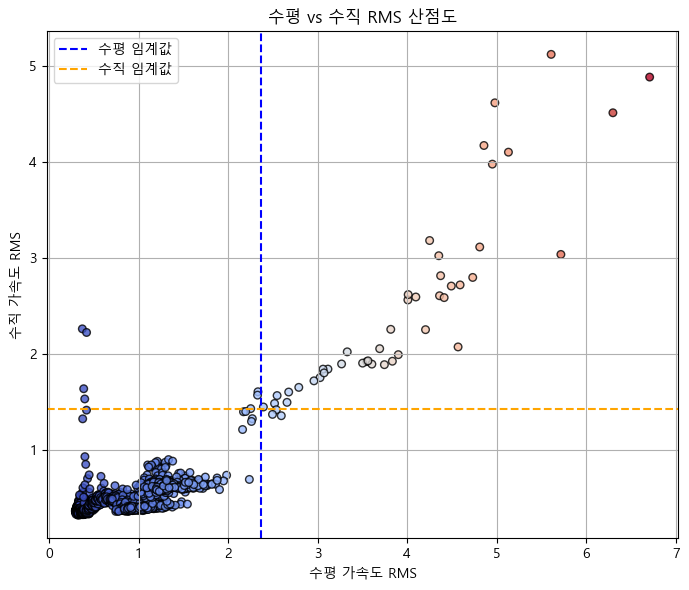

In [ ]:
# 수평 vs 수직 RMS 산점도
plt.figure(figsize=(7, 6))

# 점 크기 확대, 색상 지정, 엣지컬러로 이상 강조
plt.scatter(
    rms_horizontal, rms_vertical,
    c=rms_horizontal,  # 색상은 수평 RMS로 매핑
    cmap='coolwarm',   # 시각적 대비 좋은 컬러맵
    alpha=0.8,
    edgecolor='k',
    s=30
)

# 기준선 표시 (통계 기반 threshold)
plt.axvline(2.37, color='blue', linestyle='--', label='수평 임계값')
plt.axhline(1.42, color='orange', linestyle='--', label='수직 임계값')

plt.xlabel('수평 가속도 RMS')
plt.ylabel('수직 가속도 RMS')
plt.title('수평 vs 수직 RMS 산점도')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



색상 의미
- 점의 색은 수평 RMS 크기에 따라 컬러맵(coolwarm)으로 색을 입힌 것입니다.

    - 짙은 파랑: 수평 RMS 낮음 (정상 범주)

    - 붉은색: 수평 RMS 큼 (고장 가능성 높음)

    - 중간색: 경계 상태 또는 점진적 이상 진행 가능성

임계값 선
- 파란 점선 (x=2.37): 수평 가속도 이상 탐지 기준 (통계 기반 임계값)

- 주황 점선 (y=1.42): 수직 가속도 이상 탐지 기준

점들이 대각선 방향으로 퍼져 있는 양상은 두 변수 간 양의 공분산이 존재함을 시사하며,
고장 상태에서는 진동이 수평과 수직 모두에서 비정상적으로 증가한다는 사실을 시각적으로 확인할 수 있습니다.

이를 통해 임계값 기반의 이진 판별을 넘어서, 진동 패턴의 연관성까지 고려한 다차원적 이상 감지가 가능함을 알 수 있습니다.

In [20]:
import numpy as np

# 배열로 변환
rms_horizontal = np.array(rms_horizontal)
rms_vertical = np.array(rms_vertical)

# 통계 기반 임계값 계산
mean_h = np.mean(rms_horizontal)
std_h = np.std(rms_horizontal)
threshold_h = mean_h + 3 * std_h

mean_v = np.mean(rms_vertical)
std_v = np.std(rms_vertical)
threshold_v = mean_v + 3 * std_v

print(f"[수평 RMS] 평균: {mean_h:.4f}, 표준편차: {std_h:.4f}, 임계값 (mean + 3σ): {threshold_h:.4f}")
print(f"[수직 RMS] 평균: {mean_v:.4f}, 표준편차: {std_v:.4f}, 임계값 (mean + 3σ): {threshold_v:.4f}")


[수평 RMS] 평균: 0.6764, 표준편차: 0.5649, 임계값 (mean + 3σ): 2.3710
[수직 RMS] 평균: 0.4795, 표준편차: 0.3140, 임계값 (mean + 3σ): 1.4215


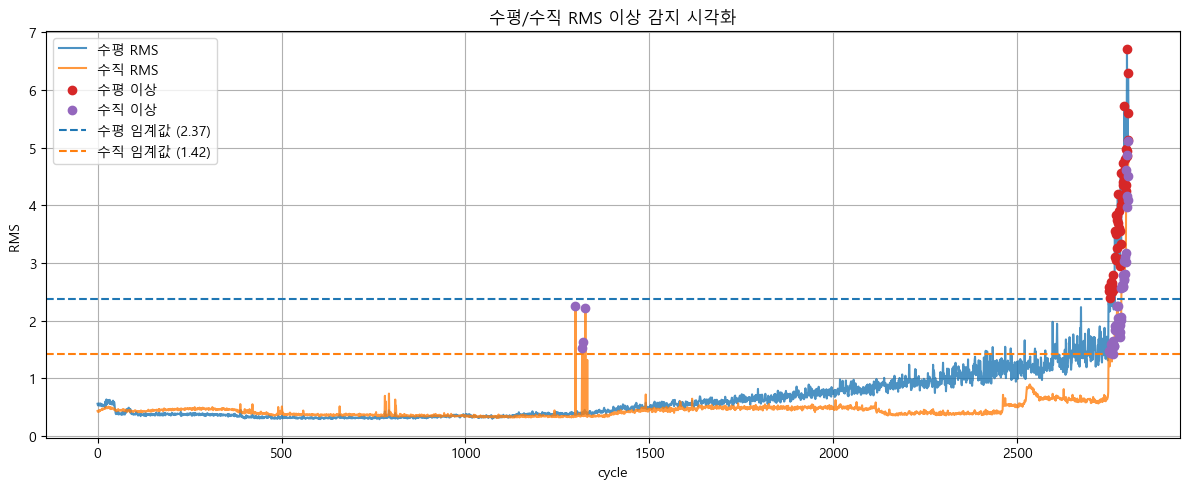

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 배열로 변환
rms_horizontal = np.array(rms_horizontal)
rms_vertical = np.array(rms_vertical)

# 통계 기반 임계값 계산
threshold_h = np.mean(rms_horizontal) + 3 * np.std(rms_horizontal)
threshold_v = np.mean(rms_vertical) + 3 * np.std(rms_vertical)

# 이상 탐지 인덱스
anomaly_idx_h = np.where(rms_horizontal > threshold_h)[0]
anomaly_idx_v = np.where(rms_vertical > threshold_v)[0]

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(rms_horizontal, label='수평 RMS', color='#1f77b4', alpha=0.8)  # 파란색 계열
plt.plot(rms_vertical, label='수직 RMS', color='#ff7f0e', alpha=0.8)    # 주황색 계열

plt.scatter(anomaly_idx_h, rms_horizontal[anomaly_idx_h], color='#d62728', label='수평 이상', zorder=3)  # 진한 빨강
plt.scatter(anomaly_idx_v, rms_vertical[anomaly_idx_v], color='#9467bd', label='수직 이상', zorder=3)  # 보라 계열

plt.axhline(y=threshold_h, color='#1f77b4', linestyle='--', linewidth=1.5, label=f'수평 임계값 ({threshold_h:.2f})')
plt.axhline(y=threshold_v, color='#ff7f0e', linestyle='--', linewidth=1.5, label=f'수직 임계값 ({threshold_v:.2f})')

plt.xlabel('cycle')
plt.ylabel('RMS ')
plt.title('수평/수직 RMS 이상 감지 시각화')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

# --- 파라미터 ---
window_size = 128  # 시계열 윈도우 크기

# --- Bearing1_1 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- 평균 진동값으로 축소 (1D 특징화) ---
def extract_feature_mean(data_list):
    return np.array([df.mean().values for df in data_list])  # shape: (time, 3축)

X_train_all = extract_feature_mean(train_raw)  # (n_samples, 3)
X_test_all = extract_feature_mean(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 구성 ---
def make_window_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(len(data) - (i + window_size))  # RUL: 마지막 시점에서 얼마나 남았는지
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size)
X_test, y_test = make_window_dataset(X_test_all, window_size)

print("Train X:", X_train.shape)  # (N, window_size, 3)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)


Train X: (2675, 128, 6)
Train y: (2675,)
Test X: (1674, 128, 6)
Test y: (1674,)


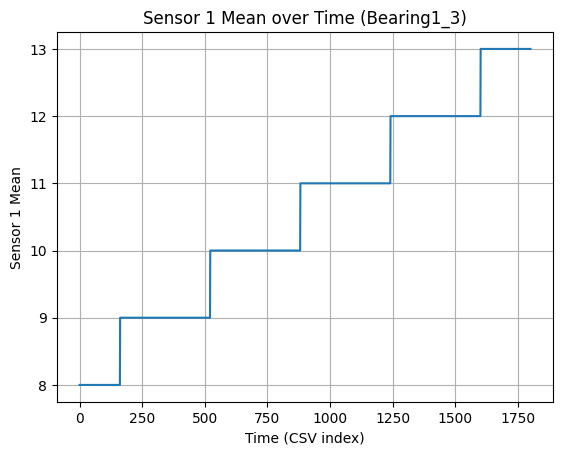

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Bearing1_3 CSV 로드 ---
folder = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"
files = sorted([f for f in os.listdir(folder) if f.endswith('.csv')])

sensor1_means = []

for f in files:
    df = pd.read_csv(os.path.join(folder, f), header=None)
    sensor1_means.append(df.iloc[:, 0].mean())  # 1번 센서 평균

# --- 시각화 ---
plt.plot(sensor1_means)
plt.title("Sensor 1 Mean over Time (Bearing1_3)")
plt.xlabel("Time (CSV index)")
plt.ylabel("Sensor 1 Mean")
plt.grid(True)
plt.show()

# CNN+LSTM 모델

Train X: (2675, 128, 6)
Train y: (2675,)
Epoch 1/50
168/168 [==============================] - 48s 265ms/step - loss: 888.7267 - mae: 25.5065 - val_loss: 27.4815 - val_mae: 3.2544
Epoch 2/50
168/168 [==============================] - 43s 258ms/step - loss: 15.2472 - mae: 1.0750 - val_loss: 23.7216 - val_mae: 1.3049
Epoch 3/50
168/168 [==============================] - 43s 258ms/step - loss: 14.9765 - mae: 0.8800 - val_loss: 23.7014 - val_mae: 1.3517
Epoch 4/50
168/168 [==============================] - 43s 257ms/step - loss: 14.9988 - mae: 0.9342 - val_loss: 23.6928 - val_mae: 1.3287
Epoch 5/50
168/168 [==============================] - 44s 262ms/step - loss: 14.9875 - mae: 0.8878 - val_loss: 23.7248 - val_mae: 1.2007
Epoch 6/50
168/168 [==============================] - 44s 261ms/step - loss: 14.9762 - mae: 0.9127 - val_loss: 23.8244 - val_mae: 1.0307
Epoch 7/50
168/168 [==============================] - 43s 259ms/step - loss: 14.9718 - mae: 0.8939 - val_loss: 23.6706 - val_mae: 1.230

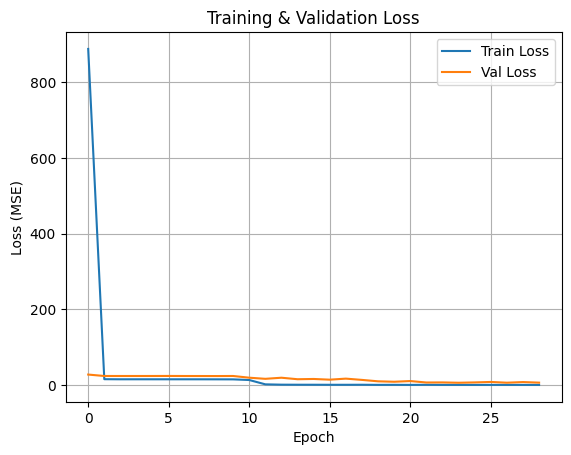

In [ ]:
# Input: (128, 6) ← 128초 동안의 RMS 특징 (6개 센서)
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

window_size = 128
MAX_RUL = 50  # 클리핑 범위 축소

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 기반 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

X_train_all = extract_feature_rms(train_raw)
X_test_all = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 + RUL 클리핑 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

53/53 [==============================] - 8s 141ms/step
MAE: 0.4959
RMSE: 2.4158
R²: 0.7528


In [ ]:
# 모델 저장 (HDF5 형식)
model.save("phm_RUL_model.h5")
print("모델이 'phm_RUL_model.h5'로 저장되었습니다.")

모델이 'phm_RUL_model.h5'로 저장되었습니다.


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


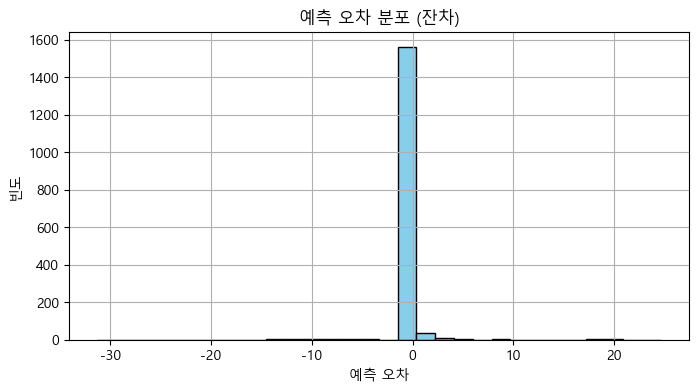

In [19]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('예측 오차 분포 (잔차)')
plt.xlabel('예측 오차')
plt.ylabel('빈도')
plt.grid(True)
plt.show()


In [2]:
from tensorflow.keras.models import load_model

# 저장된 모델 파일 경로
model = load_model("phm_RUL_model.h5")


In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 설정값
window_size = 128
MAX_RUL = 50

# 경로 설정
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])

def make_window_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(rul)  # 클리핑 없음
    return np.array(X), np.array(y)

# 테스트 데이터 로딩 및 전처리
test_raw = load_bearing_data(test_dir)
X_test_all = extract_feature_rms(test_raw)

# 스케일러 다시 fit (or 학습용 scaler 저장해놨다면 load)
scaler = MinMaxScaler()
X_test_all = scaler.fit_transform(X_test_all)

X_test, y_test = make_window_dataset(X_test_all, window_size)

53/53 [==============================] - 4s 64ms/step


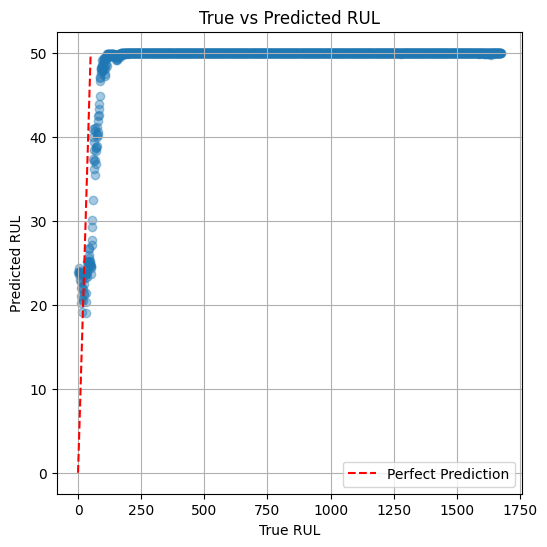

In [11]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model("phm_RUL_model.h5")
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, MAX_RUL], [0, MAX_RUL], 'r--', label='Perfect Prediction')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
model.save("cnn_lstm_rul_baseline_bearing1_1.h5")
print("기존 모델 저장 완료: cnn_lstm_rul_baseline_bearing1_1.h5")


기존 모델 저장 완료: cnn_lstm_rul_baseline_bearing1_1.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 설정값 ---
bearing_folders = [f"Bearing1_{i}" for i in range(1, 8)]  # 1_1 ~ 1_7
base_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set"
window_size = 128
MAX_RUL = None  # 클리핑 없음

# --- 함수 정의 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

def make_window_dataset(data, window_size, max_rul=None):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        if max_rul is not None:
            rul = min(rul, max_rul)
        y.append(rul)
    return np.array(X), np.array(y)

# --- 모든 Bearing 통합 ---
X_all, y_all = [], []
for bearing in bearing_folders:
    folder = os.path.join(base_dir, bearing)
    raw = load_bearing_data(folder)
    features = extract_feature_rms(raw)
    X_b, y_b = make_window_dataset(features, window_size, MAX_RUL)
    X_all.append(X_b)
    y_all.append(y_b)

X_train = np.concatenate(X_all, axis=0)
y_train = np.concatenate(y_all, axis=0)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])  # (N×128, 6)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

print("학습 데이터 통합 완료")
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


| 세트           | 고장 종류 예측 가능 여부 |
| ------------ | -------------- | 
| `Bearing1_1` | 내륜 고장          | 
| `Bearing1_2` | 외륜 고장          | 
| `Bearing2_1` | 외륜 고장          | 
| `Bearing2_2` | 볼 고장           | 
| `Bearing3_1` | 외륜 고장          | 
| `Bearing3_2` | 볼 고장           | 


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 설정값 ---
bearing_folders = [
    "Bearing1_1", "Bearing1_2",
    "Bearing2_1", "Bearing2_2",
    "Bearing3_1", "Bearing3_2"
]
base_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set"
window_size = 128
MAX_RUL = None  # 클리핑 없이 원래 수명 사용

# --- 함수 정의 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

def make_window_dataset(data, window_size, max_rul=None):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        if max_rul is not None:
            rul = min(rul, max_rul)
        y.append(rul)
    return np.array(X), np.array(y)

# --- 모든 Bearing 데이터 통합 ---
X_all, y_all = [], []

for bearing in bearing_folders:
    folder_path = os.path.join(base_dir, bearing)
    raw = load_bearing_data(folder_path)
    features = extract_feature_rms(raw)
    X_bearing, y_bearing = make_window_dataset(features, window_size, MAX_RUL)
    X_all.append(X_bearing)
    y_all.append(y_bearing)

X_train = np.concatenate(X_all, axis=0)
y_train = np.concatenate(y_all, axis=0)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])         # (전체×128, 6)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

# --- 확인 ---
print(" 다중 Bearing 학습 데이터 통합 완료")
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


 다중 Bearing 학습 데이터 통합 완료
X_train shape: (6766, 128, 6)
y_train shape: (6766,)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(window_size, 6)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 64)           1984      
                                                                 
 dropout (Dropout)           (None, 124, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37121 (145.00 KB)
Trainable params: 37121

In [17]:
# 기존 y_train → 로그 스케일로 변환
y_train_log = np.log1p(y_train)  # log(1 + RUL)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(window_size, 6)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_lstm_multibearing_log.h5", save_best_only=True)

history = model.fit(
    X_train_scaled, y_train_log,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
339/339 [==============================] - 35s 96ms/step - loss: 3.2968 - mae: 1.2587 - val_loss: 1.1210 - val_mae: 0.9323
Epoch 2/50
339/339 [==============================] - 31s 92ms/step - loss: 0.8188 - mae: 0.7017 - val_loss: 0.5453 - val_mae: 0.6859
Epoch 3/50
339/339 [==============================] - 30s 90ms/step - loss: 0.5119 - mae: 0.5642 - val_loss: 2.5635 - val_mae: 1.5471
Epoch 4/50
339/339 [==============================] - 30s 89ms/step - loss: 0.4352 - mae: 0.5208 - val_loss: 3.5343 - val_mae: 1.7516
Epoch 5/50
339/339 [==============================] - 30s 90ms/step - loss: 0.3525 - mae: 0.4734 - val_loss: 2.3363 - val_mae: 1.4605
Epoch 6/50
339/339 [==============================] - 31s 92ms/step - loss: 0.3248 - mae: 0.4522 - val_loss: 1.9809 - val_mae: 1.3382
Epoch 7/50
339/339 [==============================] - 30s 90ms/step - loss: 0.2670 - mae: 0.4118 - val_loss: 2.4448 - val_mae: 1.4865
Epoch 8/50
339/339 [==============================] - 30s 89ms

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 예측
y_pred_log = model.predict(X_train_scaled)

# 역변환 (log1p → expm1)
y_true = np.expm1(y_train_log)
y_pred = np.expm1(y_pred_log)

# 평가 지표 계산
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"성능 평가 (log1p 역변환 기준):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")   # 성능 하락  

212/212 [==============================] - 12s 55ms/step
성능 평가 (log1p 역변환 기준):
MAE: 306.88
RMSE: 360.98
R²: 0.7337


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 64)           1216      
                                                                 
 dropout_4 (Dropout)         (None, 126, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 71425 (279.00 KB)
Trainable params: 71425 (279.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

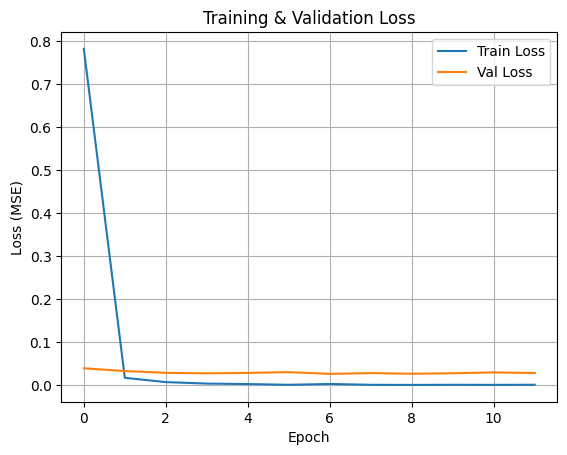

53/53 [==============================] - 25s 451ms/step

 성능 평가 (log1p 역변환 기준):
MAE: 3.05
RMSE: 4.07
R²: 0.2984


In [ ]:
# Bidirectional LSTM + log1p RULBidirectional LSTM + log1p RUL
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"

window_size = 128
MAX_RUL = 50  # RUL 클리핑

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

X_train_all = extract_feature_rms(train_raw)
X_test_all = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 윈도우 + log1p RUL ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

# 로그 변환
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 학습 ---
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train_log,
    validation_data=(X_test, y_test_log),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.grid(True)
plt.show()

# --- 성능 평가 (log1p 역변환 기준) ---
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n 성능 평가 (log1p 역변환 기준):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")  #BiLSTM+CNN  -> 성능하락

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 6)]             0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 128, 64)              448       ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 128, 64)              0         ['dense_6[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 128, 64)              66368     ['tf.__operators__.add[0][

c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


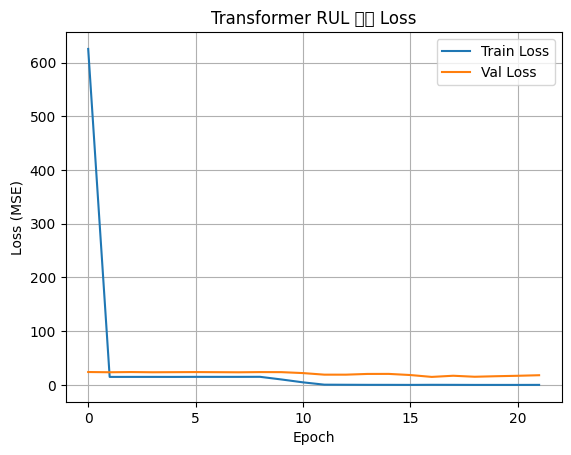

53/53 [==============================] - 11s 201ms/step

 Transformer 성능 평가:
MAE: 0.6220
RMSE: 3.8698
R²: 0.3658


In [ ]:
#transformer
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# 설정

train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50


# 데이터 로딩 및 전처리
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점, 센서수)

def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

X_train_all = extract_feature_rms(train_raw)
X_test_all = extract_feature_rms(test_raw)

scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)


# Positional Encoding 함수
def positional_encoding(length, d_model):
    angle_rads = np.arange(length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 짝수
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 홀수
    return tf.cast(angle_rads, dtype=tf.float32)  # (length, d_model)


# Transformer Encoder 모델 정의
def build_transformer_model(window_size, num_features, d_model=64, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=(window_size, num_features))

    # Positional Encoding 추가
    pos_encoding = positional_encoding(window_size, d_model)
    x = Dense(d_model)(inputs)
    x += pos_encoding

    # Multi-Head Attention + FF
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    x = Dropout(dropout_rate)(x)

    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(d_model)(ff_output)
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)
    x = Dropout(dropout_rate)(x)

    # Global Average Pooling → RUL 출력
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# 모델 학습 및 평가
model = build_transformer_model(window_size, X_train.shape[2])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Transformer RUL 예측 Loss')
plt.grid(True)
plt.show()


# 성능 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Transformer 성능 평가:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Train X: (2675, 128, 36)
Train y: (2675,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           6976      
                                                                 
 batch_normalization (Batch  (None, 126, 64)           256       
 Normalization)                                                  
                                                                 
 dropout_7 (Dropout)         (None, 126, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 126, 64)           33024     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
            

c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


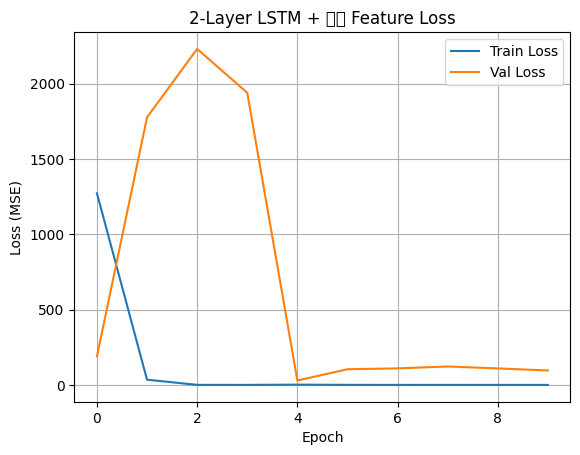

53/53 [==============================] - 16s 282ms/step

2-Layer LSTM 성능 평가:
MAE: 4.1322
RMSE: 5.4170
R²: -0.2427


In [ ]:
# CNN-LSTM 하이브리드
# CNN	시계열 내 짧은 구간(국소 특징) 추출에 강함
# LSTM	시계열의 장기 의존성(long-term dependency) 학습에 강함
# 하이브리드	CNN으로 저수준 특징 추출 → LSTM으로 고수준 시계열 관계 학습
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 로딩 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- 통계 기반 특징 추출 (6개 센서 × 6개 통계 = 36개 피처) ---
def extract_nasa_stat_features(data_list):
    feature_list = []
    for df in data_list:  # df: (6,) 센서값이 시간축으로 쌓인 데이터프레임
        rms = np.sqrt((df**2).mean()).values
        mean = df.mean().values
        std = df.std().values
        max_ = df.max().values
        min_ = df.min().values
        ptp = (df.max() - df.min()).values
        feature = np.concatenate([rms, mean, std, max_, min_, ptp])
        feature_list.append(feature)
    return np.array(feature_list)  # shape: (time, 36)

X_train_all = extract_nasa_stat_features(train_raw)
X_test_all = extract_nasa_stat_features(test_raw)
# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)  # (samples, 128, 36)
print("Train y:", y_train.shape)

# --- 모델 구성 (Conv1D + LSTM 2층) ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 학습 ---
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- Loss 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('2-Layer LSTM + 통계 Feature Loss')
plt.grid(True)
plt.show()

# --- 성능 평가 ---
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n2-Layer LSTM 성능 평가:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")  #CNN이 흐름을 깨고 있을 가능성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# y 값 log 변환
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 단순 LSTM 2층 모델 (CNN 제거)
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train_log,  # log 변환된 타깃
    validation_data=(X_test, y_test_log),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# 예측 후 다시 원래 값으로 복원 (log1p의 역함수)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # ← exp(log(RUL) + 1) - 1

# 실제 y_test도 복원
y_test_true = np.expm1(y_test_log)

# 평가
mae = mean_absolute_error(y_test_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print(f"\n개선된 단순 LSTM 성능:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


X_train: (2675, 128, 36)
y_train: (2675,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128, 64)           25856     
                                                                 
 dropout_8 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 39361 (153.75 KB)
Trainable params: 39361 (153.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

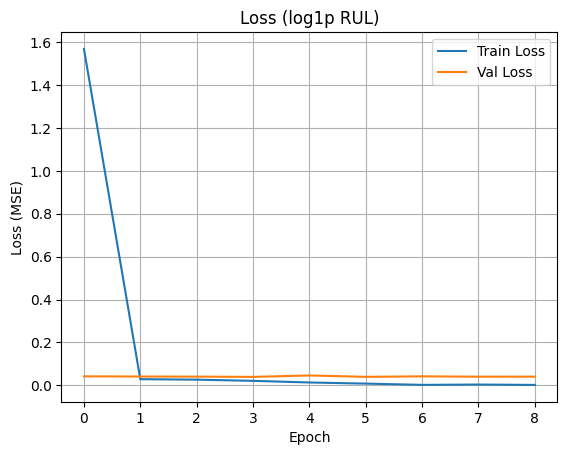

53/53 [==============================] - 14s 240ms/step

최종 성능 평가:
MAE: 1.2407
RMSE: 4.5879
R²: 0.1086


In [35]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 로딩 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- 통계 기반 피처 추출 (6개 센서 × 6개 통계 = 36차원) ---
def extract_stat_features(data_list):
    feature_list = []
    for df in data_list:
        rms = np.sqrt((df**2).mean()).values
        mean = df.mean().values
        std = df.std().values
        max_ = df.max().values
        min_ = df.min().values
        ptp = (df.max() - df.min()).values
        feature = np.concatenate([rms, mean, std, max_, min_, ptp])  # 총 36차원
        feature_list.append(feature)
    return np.array(feature_list)

X_train_all = extract_stat_features(train_raw)
X_test_all = extract_stat_features(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 생성 + RUL 클리핑 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

# --- log1p 변환 (출력 안정화 목적) ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- LSTM 모델 구성 (단순 구조) ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 학습 ---
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train_log,
    validation_data=(X_test, y_test_log),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Loss (log1p RUL)')
plt.grid(True)
plt.show()

# --- 예측 및 복원 ---
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # log1p 역변환
y_test_true = np.expm1(y_test_log)

# --- 평가 ---
mae = mean_absolute_error(y_test_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print(f"\n최종 성능 평가:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# --- 경로 설정 ---
base_path = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master"
learning_dirs = [os.path.join(base_path, "Learning_set", f"Bearing1_{i}") for i in [1, 2]]
test_dirs = [os.path.join(base_path, "Test_set", f"Bearing1_{i}") for i in [3, 4, 5, 6, 7, 8]]
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_paths):
    data_list = []
    for folder_path in folder_paths:
        file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
        for f in file_list:
            df = pd.read_csv(os.path.join(folder_path, f), header=None)
            data_list.append(df)
    return data_list

train_raw = load_bearing_data(learning_dirs)
test_raw = load_bearing_data(test_dirs)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

X_train_all = extract_feature_rms(train_raw)
X_test_all = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 + RUL ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Test X:", X_test.shape)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- 모델 저장 및 학습 설정 ---
model_path = "best_rul_model.h5"
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

# --- 학습 ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# --- 성능 평가 ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\n성능 평가:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

# --- 파라미터 ---
window_size = 128  # 시계열 윈도우 크기

# --- Bearing1_1 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- 평균 진동값으로 축소 (1D 특징화) ---
def extract_feature_mean(data_list):
    return np.array([df.mean().values for df in data_list])  # shape: (time, 3축)

X_train_all = extract_feature_mean(train_raw)  # (n_samples, 3)
X_test_all = extract_feature_mean(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 구성 ---
def make_window_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(len(data) - (i + window_size))  # RUL: 마지막 시점에서 얼마나 남았는지
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size)
X_test, y_test = make_window_dataset(X_test_all, window_size)

print("Train X:", X_train.shape)  # (N, window_size, 3)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Train X: (2675, 128, 6)
Train y: (2675,)
Test X: (1674, 128, 6)
Test y: (1674,)


In [7]:
#############################################

Train X: (2675, 128, 6)
Train y: (2675,)
Epoch 1/50
168/168 [==============================] - 57s 319ms/step - loss: 1059.2057 - mae: 29.8887 - val_loss: 90.8032 - val_mae: 9.1784
Epoch 2/50
168/168 [==============================] - 53s 317ms/step - loss: 23.8146 - mae: 2.6737 - val_loss: 23.7273 - val_mae: 1.2037
Epoch 3/50
168/168 [==============================] - 53s 313ms/step - loss: 14.9537 - mae: 0.8994 - val_loss: 23.7217 - val_mae: 1.2054
Epoch 4/50
168/168 [==============================] - 53s 313ms/step - loss: 14.9555 - mae: 0.8966 - val_loss: 23.7004 - val_mae: 1.2411
Epoch 5/50
168/168 [==============================] - 52s 313ms/step - loss: 14.9480 - mae: 0.9005 - val_loss: 23.7569 - val_mae: 1.1260
Epoch 6/50
168/168 [==============================] - 52s 313ms/step - loss: 14.9590 - mae: 0.9071 - val_loss: 23.7474 - val_mae: 1.1323
Epoch 7/50
168/168 [==============================] - 52s 311ms/step - loss: 14.9672 - mae: 0.8867 - val_loss: 23.7047 - val_mae: 1.19

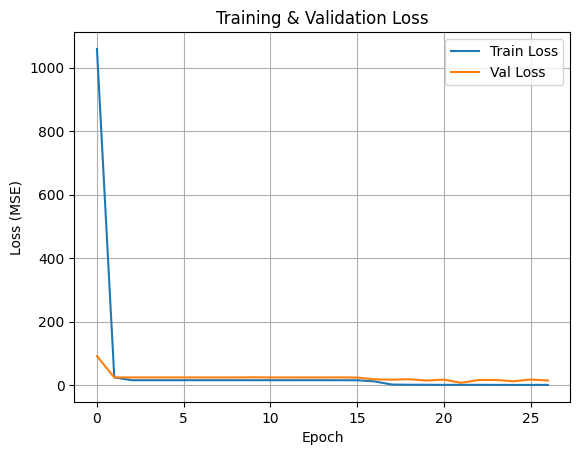

In [5]:
# Input: (128, 6) ← 128초 동안의 RMS 특징 (6개 센서)
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

window_size = 128
MAX_RUL = 50  # 클리핑 범위 축소

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 기반 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape: (time, 6)

X_train_all = extract_feature_rms(train_raw)
X_test_all = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

# --- 시계열 윈도우 + RUL 클리핑 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.grid(True)
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 모델 저장
model.save("final2_RUL_model.h5")
print("모델이 'final2_RUL_model.h5'로 저장되었습니다.")

53/53 [==============================] - 10s 169ms/step
MAE: 0.6169
RMSE: 2.5694
R²: 0.7204
모델이 'final2_RUL_model.h5'로 저장되었습니다.


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


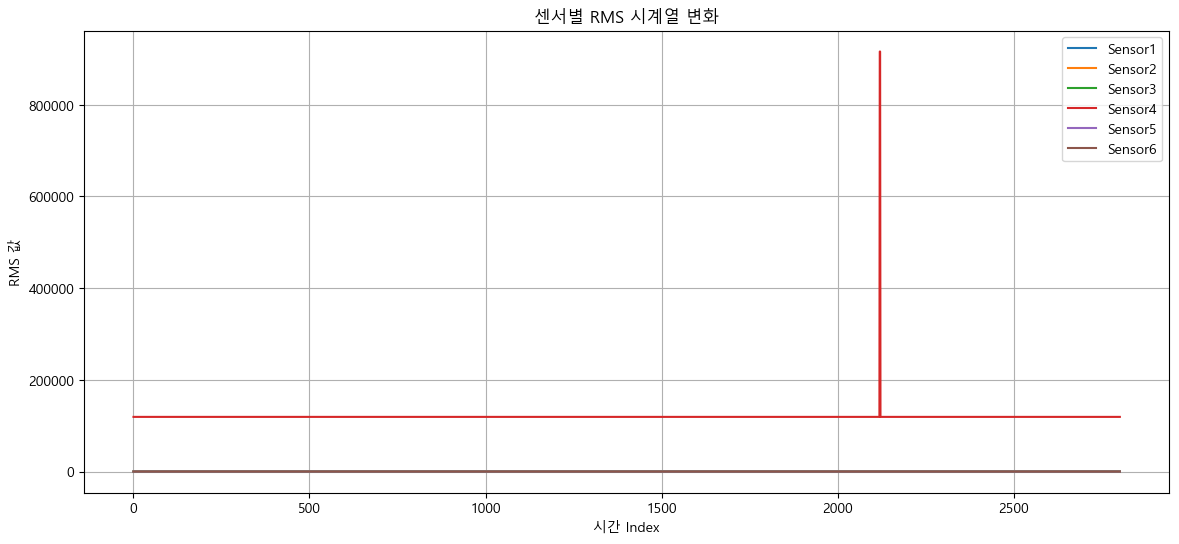

In [ ]:
import matplotlib.pyplot as plt

# Bearing1_1의 각 센서별 RMS 시계열 (X_train_all은 정규화 전 데이터 사용 권장)
rms_df = pd.DataFrame(extract_feature_rms(train_raw), columns=[f'Sensor{i+1}' for i in range(6)])
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 6))
for i in range(6):
    plt.plot(rms_df[f'Sensor{i+1}'], label=f'Sensor{i+1}')
plt.xlabel('시간 Index')
plt.ylabel('RMS 값')
plt.title('센서별 RMS 시계열 변화')
plt.legend()
plt.grid(True)
plt.show()

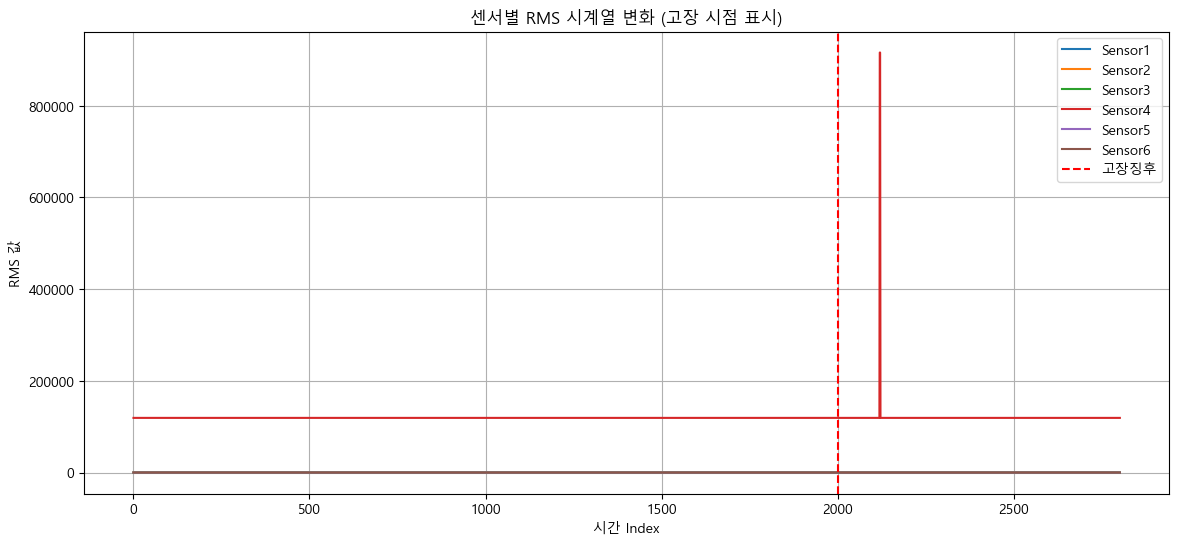

In [ ]:
plt.figure(figsize=(14, 6))
for i in range(6):
    plt.plot(rms_df[f'Sensor{i+1}'], label=f'Sensor{i+1}')
plt.axvline(x=2000, color='red', linestyle='--', label='고장징후')
plt.xlabel('시간 Index')
plt.ylabel('RMS 값')
plt.title('센서별 RMS 시계열 변화 (고장 시점 표시)')
plt.legend()
plt.grid(True)
plt.show()
#2000번째 시점 이후 RMS 값이 급격히 상승하는 이상현상이 나타났다. 이는 고장 직전의 강한 진동 징후로 해석될 수 있으며, 고장이 특정 센서 위치에 국한된 국부적 문제였음을 시사한다.

| 센서 번호       | 위치/채널 의미 (추정)                             |
| ----------- | ----------------------------------------- |
| Sensor1     | DE 축 진동 (Drive End)                       |
| Sensor2     | FE 축 진동 (Fan End)                         |
| Sensor3     | 주변 온도 / 서브 센서                             |
| **Sensor4** | **구동축 진동 - 원시값의 특정 축 (예: X, Y, Z 중 하나)** |
| Sensor5     | FE 축 진동 - 보조 채널                           |
| Sensor6     | 속도 / 회전수 관련 센서일 수 있음                      |


In [23]:
from sklearn.ensemble import RandomForestRegressor

# RandomForest는 2D 입력 필요
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_all[:-window_size], y_train)  # window 이후 샘플만 대응 가능

importances = rf.feature_importances_
for i, imp in enumerate(importances):
    print(f"Sensor{i+1} 중요도: {imp:.4f}")


Sensor1 중요도: 0.8945
Sensor2 중요도: 0.0845
Sensor3 중요도: 0.0016
Sensor4 중요도: 0.0000
Sensor5 중요도: 0.0121
Sensor6 중요도: 0.0073


Sensor1 중요도: 0.8945
Sensor2 중요도: 0.0845
Sensor3 중요도: 0.0016
Sensor4 중요도: 0.0000
Sensor5 중요도: 0.0121
Sensor6 중요도: 0.0073


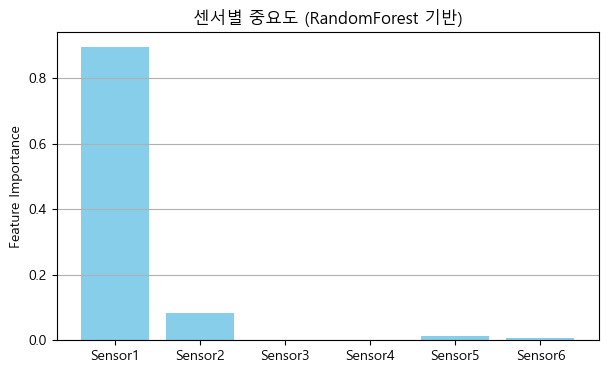

Epoch 1/50
168/168 [==============================] - 58s 324ms/step - loss: 856.5670 - mae: 25.1211 - val_loss: 30.8202 - val_mae: 3.9433
Epoch 2/50
168/168 [==============================] - 54s 323ms/step - loss: 15.5986 - mae: 1.2825 - val_loss: 23.7246 - val_mae: 1.2299
Epoch 3/50
168/168 [==============================] - 55s 326ms/step - loss: 14.9777 - mae: 0.8888 - val_loss: 23.7700 - val_mae: 1.1413
Epoch 4/50
168/168 [==============================] - 55s 326ms/step - loss: 14.9985 - mae: 0.9109 - val_loss: 23.6947 - val_mae: 1.2830
Epoch 5/50
168/168 [==============================] - 54s 321ms/step - loss: 14.9738 - mae: 0.9090 - val_loss: 23.8403 - val_mae: 1.0225
Epoch 6/50
168/168 [==============================] - 55s 328ms/step - loss: 14.9737 - mae: 0.8817 - val_loss: 23.8101 - val_mae: 1.0400
Epoch 7/50
168/168 [==============================] - 54s 321ms/step - loss: 14.8751 - mae: 0.8712 - val_loss: 23.6634 - val_mae: 1.2977
Epoch 8/50
168/168 [===================

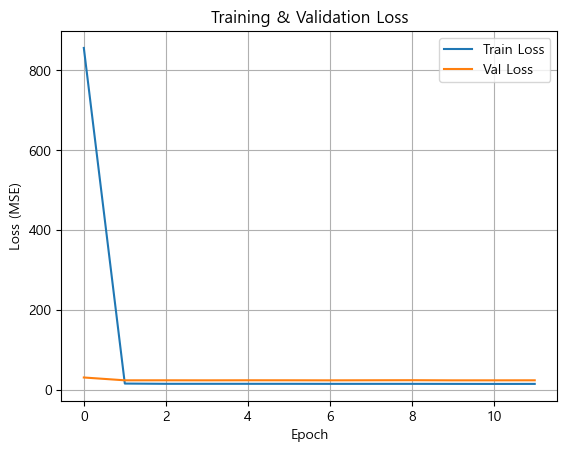

모델 저장 완료 


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 설정 ---
window_size = 128
MAX_RUL = 50

# --- 데이터 로딩 함수 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

# --- RMS 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

# --- 윈도우 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir  = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"

# --- 데이터 로딩 및 특징 추출 ---
train_raw = load_bearing_data(train_dir)
test_raw  = load_bearing_data(test_dir)

X_train_all = extract_feature_rms(train_raw)  # (시점 수, 6)
X_test_all  = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)

# --- RandomForest로 센서 중요도 평가 ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
_, y_tmp = make_window_dataset(X_train_all, window_size, MAX_RUL)
rf.fit(X_train_all[:-window_size], y_tmp)

importances = rf.feature_importances_
for i, imp in enumerate(importances):
    print(f"Sensor{i+1} 중요도: {imp:.4f}")

# --- 중요도 시각화 ---
plt.figure(figsize=(7,4))
plt.bar([f'Sensor{i+1}' for i in range(6)], importances, color='skyblue')
plt.title('센서별 중요도 (RandomForest 기반)')
plt.ylabel('Feature Importance')
plt.grid(True, axis='y')
plt.show()

#
# --- 중요 센서 선택 (예: Sensor1, Sensor2) ---
selected_indices = [0, 1]  # 중요도 기준 수동 선택 가능, 중요도 높은거 2개만 선택해서 학습

X_train_sel = X_train_all[:, selected_indices]
X_test_sel  = X_test_all[:, selected_indices]

X_train, y_train = make_window_dataset(X_train_sel, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_sel, window_size, MAX_RUL)

# --- 모델 구성 및 학습 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, len(selected_indices))),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 모델 저장 ---
model.save('rul_sensor1_2_model.h5')
print("모델 저장 완료 ")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 예측 ---
y_pred = model.predict(X_test).flatten()

# --- 성능 평가 ---
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n모델 성능 평가")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


53/53 [==============================] - 10s 182ms/step

📊 모델 성능 평가
MAE : 1.2977
RMSE: 4.8645
R²  : -0.0021


# phm 데이터 CNN+LSTM

정규화 scaler 저장 완료: scaler_sensor_all.pkl
Train X: (2675, 128, 6)
Train y: (2675,)


Epoch 1/50


168/168 [==============================] - 64s 362ms/step - loss: 660.8146 - mae: 19.9421 - val_loss: 23.7677 - val_mae: 1.3957
Epoch 2/50
168/168 [==============================] - 56s 336ms/step - loss: 15.0186 - mae: 0.8936 - val_loss: 23.8196 - val_mae: 1.1589
Epoch 3/50
168/168 [==============================] - 56s 337ms/step - loss: 15.0366 - mae: 0.9527 - val_loss: 23.7228 - val_mae: 1.2820
Epoch 4/50
168/168 [==============================] - 56s 335ms/step - loss: 14.9790 - mae: 0.9076 - val_loss: 23.7402 - val_mae: 1.1470
Epoch 5/50
168/168 [==============================] - 57s 340ms/step - loss: 14.9188 - mae: 0.8831 - val_loss: 23.6853 - val_mae: 1.1364
Epoch 6/50
168/168 [==============================] - 56s 336ms/step - loss: 14.8460 - mae: 0.9064 - val_loss: 23.5605 - val_mae: 1.2262
Epoch 7/50
168/168 [==============================] - 53s 319ms/step - loss: 14.7167 - mae:

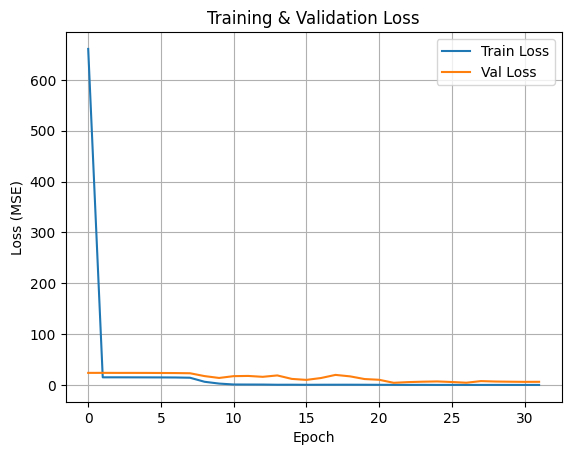

모델 저장 완료: phm_RUL_model2.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib  # 정규화 저장용
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

X_train_all = extract_feature_rms(train_raw)
X_test_all  = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)

#  scaler 저장
joblib.dump(scaler, "scaler_sensor_all.pkl")
print("정규화 scaler 저장 완료: scaler_sensor_all.pkl")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 모델 저장 (선택) ---
model.save("phm_RUL_model2.h5")
print("모델 저장 완료: phm_RUL_model2.h5")

53/53 [==============================] - 11s 194ms/step
[CNN+LSTM RUL 예측 모델 평가]
MAE: 0.43
RMSE: 2.06
R²: 0.8195


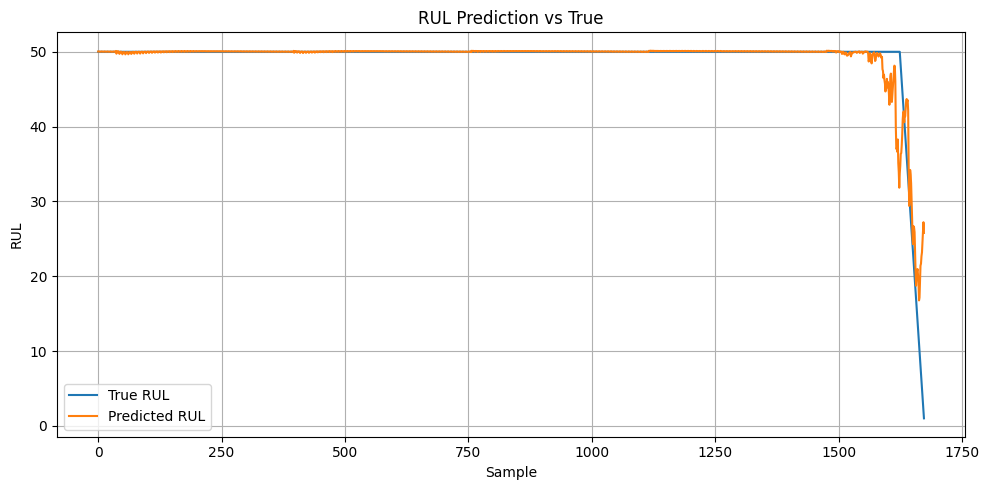

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 예측 ---
y_pred = model.predict(X_test).flatten()

# --- 역정규화 (필요 시): 현재 RUL은 정규화되지 않았으므로 생략 가능

# --- 평가 지표 ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[CNN+LSTM RUL 예측 모델 평가]")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# --- 예측 vs 실제 시각화 ---
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('RUL Prediction vs True')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
import joblib

# 모델 및 스케일러 불러오기 (필요 시)
model = load_model("phm_RUL_model2.h5")
scaler = joblib.load("scaler_sensor_all.pkl")

#  모델 백업 저장
model.save("phm_RUL_model2_backup.h5")
print("모델 백업 저장 완료: phm_RUL_model2_backup.h5")

#  스케일러 백업 저장
joblib.dump(scaler, "scaler_sensor_all_backup.pkl")
print("스케일러 백업 저장 완료: scaler_sensor_all_backup.pkl")

모델 백업 저장 완료: phm_RUL_model2_backup.h5
스케일러 백업 저장 완료: scaler_sensor_all_backup.pkl


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# nasa turbofan
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore
import joblib  # ← 정규화 저장용

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import sys
sys.path.append(r"C:\bearing2\BearingGuardian")  # 이 줄 추가
from noise_input import RealisticNoiseInjector  # 수정된 import 경로


# 1. 데이터 불러오기
train = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\train_FD001.txt", sep='\s+', header=None)
test = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\test_FD001.txt", sep='\s+', header=None)
rul = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\RUL_FD001.txt", sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)
X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# --- 정규화 저장 ---
joblib.dump(scaler, "scaler_fd001.pkl")
print("정규화 스케일러 저장 완료: scaler_fd001.pkl")

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. LSTM 모델 정의 (128 → 64 → 32 → Dense)
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(feature_cols))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))  # 최종 RUL 예측

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[LSTM Deep + Noise] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 모델 저장
model.save("lstm_rul_model_fd001.h5")
print("모델 저장 완료: lstm_rul_model_fd001.h5")


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\pandas\core\apply.py:1081: Runtim

선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
정규화 스케일러 저장 완료: scaler_fd001.pkl
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           73728     
                                                                 
 batch_normalization (Batch  (None, 30, 128)           512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 batch_normalization_1 (Bat  (N

c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 85ms/step
 성능 평가 결과:
 MAE  (평균 절대 오차): 11.49
 RMSE (평균 제곱근 오차): 15.74
 R²    (결정 계수): 0.8457


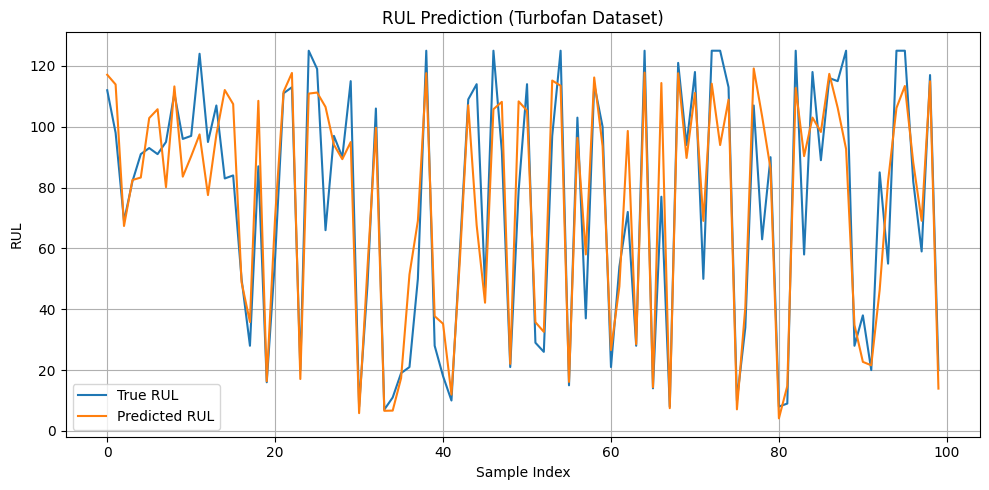

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 예측 수행
y_pred = model.predict(X_test).flatten()

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 출력
print(f" 성능 평가 결과:")
print(f" MAE  (평균 절대 오차): {mae:.2f}")
print(f" RMSE (평균 제곱근 오차): {rmse:.2f}")
print(f" R²    (결정 계수): {r2:.4f}")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('RUL Prediction (Turbofan Dataset)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# 학습 후 저장
model.save_weights("nasa_weights_only.h5")
joblib.dump(scaler, "scaler_fd001.pkl")

# (원할 경우 백업용으로 다시 저장)
model = load_model("lstm_rul_model_fd001.h5")
scaler = joblib.load("scaler_fd001.pkl")

model.save("lstm_rul_model_backup.h5")
joblib.dump(scaler, "scaler_fd001_backup.pkl")

c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler_fd001_backup.pkl']

In [ ]:
# NASA 모델 → PHM 모델로 전이 학습(fine-tuning)
# NASA에서 학습된 구조를 가져와서 PHM 데이터로 살짝 미세 조정

In [ ]:
# NASA CMAPSS 기반 모델 구조를 PHM IEEE 2012 데이터에 적용해 전이학습을 시도했으나,
# 센서 수 및 데이터 분포가 상이하여 구조적 호환성에 한계가 있었습니다.
# 특히, LSTM 계층의 가중치 shape mismatch 문제가 발생했으며,
# 이를 억지로 맞추기보다 PHM 데이터에 최적화된 모델을 새로 설계하는 방향으로 전환했습니다.

정규화 scaler 저장 완료: scaler_sensor_all2.pkl
Train X: (2675, 128, 6)
Train y: (2675,)

Epoch 1/50


168/168 [==============================] - 45s 233ms/step - loss: 31.0269 - mae: 31.5269 - val_loss: 4.8190 - val_mae: 5.3187
Epoch 2/50
168/168 [==============================] - 35s 210ms/step - loss: 0.6399 - mae: 0.7777 - val_loss: 0.7171 - val_mae: 0.7321
Epoch 3/50
168/168 [==============================] - 36s 212ms/step - loss: 0.4488 - mae: 0.4797 - val_loss: 0.7180 - val_mae: 0.7536
Epoch 4/50
168/168 [==============================] - 34s 204ms/step - loss: 0.4486 - mae: 0.4768 - val_loss: 0.7168 - val_mae: 0.7940
Epoch 5/50
168/168 [==============================] - 34s 203ms/step - loss: 0.4432 - mae: 0.4954 - val_loss: 0.7079 - val_mae: 0.7899
Epoch 6/50
168/168 [==============================] - 34s 202ms/step - loss: 0.4388 - mae: 0.4766 - val_loss: 0.7167 - val_mae: 0.7574
Epoch 7/50
168/168 [==============================] - 33s 195ms/step - loss: 0.4493 - mae: 0.4907 - val

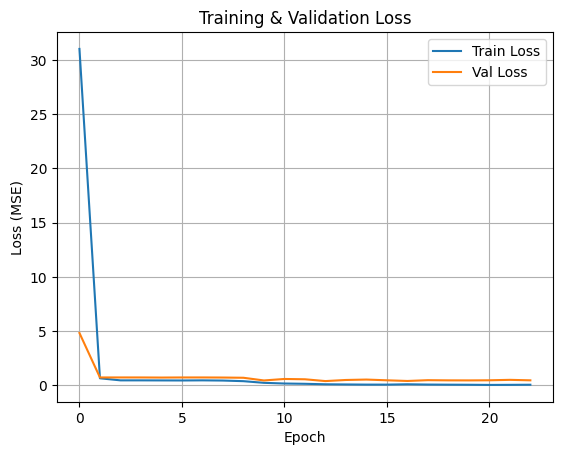

모델 저장 완료: phm_RUL_model22.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# 더 깊은 CNN/LSTM 계층 사용,손실 함수 변형
# RUL은 작은 오차보다 큰 오차에 민감 → Huber Loss 등도 고려
import os
from tensorflow.keras.losses import Huber
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib  # 정규화 저장용
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 경로 설정 ---
train_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"

window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

X_train_all = extract_feature_rms(train_raw)
X_test_all  = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)

#  scaler 저장
joblib.dump(scaler, "scaler_sensor_all2.pkl")
print("정규화 scaler 저장 완료: scaler_sensor_all2.pkl")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 ---
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, activation='relu'),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])


# --- 학습 ---
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 모델 저장 (선택) ---
model.save("phm_RUL_model22.h5")
print("모델 저장 완료: phm_RUL_model22.h5")

53/53 [==============================] - 4s 81ms/step
📊 성능 평가 결과:
MAE:  0.4389
RMSE: 2.3308
R²:   0.7699


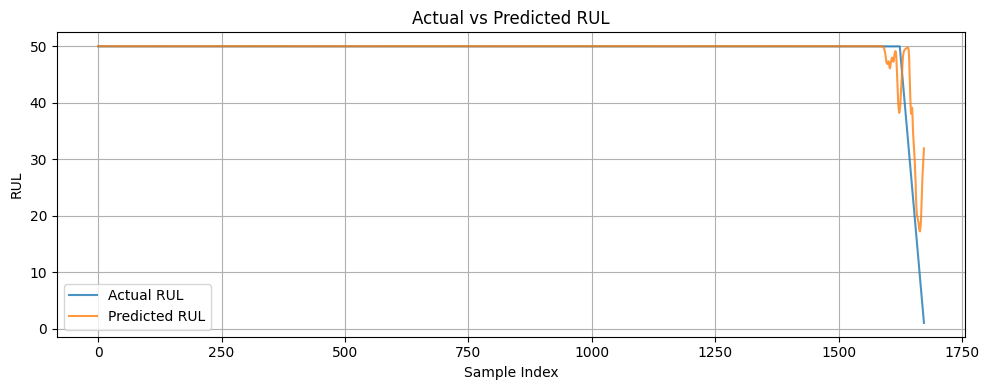

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 예측 수행 ---
y_pred = model.predict(X_test).flatten()

# --- 성능 지표 계산 ---
# --- 성능 지표 계산 ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 제곱근 수동 계산
r2 = r2_score(y_test, y_pred)


print(f"📊 성능 평가 결과:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# --- 예측 vs 실제 시각화 ---
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual RUL', alpha=0.8)
plt.plot(y_pred, label='Predicted RUL', alpha=0.8)
plt.title("Actual vs Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# CNN 2층 + LSTM 2층 + Dense (심층 구조), 손실 함수는 Huber() (큰 오차에 덜 민감)-->성능 하락

정규화 scaler 저장 완료
Train X: (2675, 128, 6)
Train y: (2675,)
Epoch 1/50
168/168 [==============================] - 52s 289ms/step - loss: 16.4638 - mae: 16.8581 - val_loss: 0.7277 - val_mae: 0.8607
Epoch 2/50
168/168 [==============================] - 47s 282ms/step - loss: 0.4512 - mae: 0.5004 - val_loss: 0.7233 - val_mae: 0.8214
Epoch 3/50
168/168 [==============================] - 47s 281ms/step - loss: 0.4508 - mae: 0.5001 - val_loss: 0.7204 - val_mae: 0.8015
Epoch 4/50
168/168 [==============================] - 47s 280ms/step - loss: 0.4503 - mae: 0.4950 - val_loss: 0.7185 - val_mae: 0.7662
Epoch 5/50
168/168 [==============================] - 48s 284ms/step - loss: 0.4494 - mae: 0.4985 - val_loss: 0.7181 - val_mae: 0.7587
Epoch 6/50
168/168 [==============================] - 47s 280ms/step - loss: 0.4468 - mae: 0.4917 - val_loss: 0.7186 - val_mae: 0.8065
Epoch 7/50
168/168 [==============================] - 47s 280ms/step - loss: 0.4489 - mae: 0.5022 - val_loss: 0.7167 - val_mae: 0.

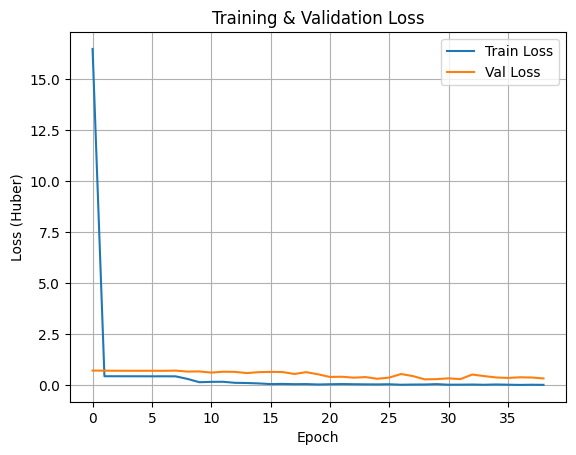

53/53 [==============================] - 8s 145ms/step

 성능 평가 결과:
MAE : 0.3810
RMSE: 1.7601
R²   : 0.8688
모델 저장 완료: phm_RUL_model_Huber.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# Huber Loss + 단층 LSTM 
# RUL은 작은 오차보다 큰 오차에 민감 → Huber Loss 등도 고려
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

X_train_all = extract_feature_rms(train_raw)
X_test_all  = extract_feature_rms(test_raw)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)
joblib.dump(scaler, "scaler_sensor_all2.pkl")
print("정규화 scaler 저장 완료")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 (단층 + Huber) ---
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 예측 및 성능 평가 ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n 성능 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# --- 모델 저장 ---
model.save("phm_RUL_model_Huber.h5")
print("모델 저장 완료: phm_RUL_model_Huber.h5")


정규화 scaler 저장 완료
Train X: (2675, 128, 6)
Train y: (2675,)


Epoch 1/50


168/168 [==============================] - 85s 485ms/step - loss: 18.7452 - mae: 19.1704 - val_loss: 0.7256 - val_mae: 0.8212
Epoch 2/50
168/168 [==============================] - 73s 436ms/step - loss: 0.4510 - mae: 0.4977 - val_loss: 0.7188 - val_mae: 0.7584
Epoch 3/50
168/168 [==============================] - 76s 450ms/step - loss: 0.4505 - mae: 0.4933 - val_loss: 0.7182 - val_mae: 0.7641
Epoch 4/50
168/168 [==============================] - 76s 451ms/step - loss: 0.4501 - mae: 0.4915 - val_loss: 0.7180 - val_mae: 0.7693
Epoch 5/50
168/168 [==============================] - 74s 438ms/step - loss: 0.4501 - mae: 0.4928 - val_loss: 0.7189 - val_mae: 0.8070
Epoch 6/50
168/168 [==============================] - 73s 434ms/step - loss: 0.4500 - mae: 0.4921 - val_loss: 0.7182 - val_mae: 0.7494
Epoch 7/50
168/168 [==============================] - 71s 425ms/step - loss: 0.4505 - mae: 0.5035 - val_loss: 0.7173 - val_mae

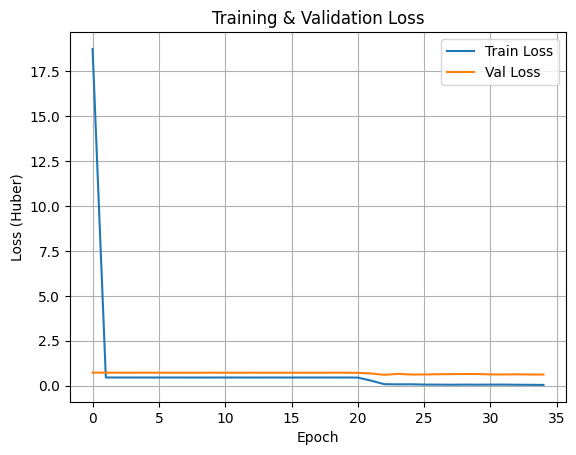

53/53 [==============================] - 14s 249ms/step

 성능 평가 결과:
MAE : 0.6276
RMSE: 4.0921
R²   : 0.2908
모델 저장 완료: phm_RUL_model_Huber2.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# cnn+lstm  + 노이즈 추가
# Huber Loss + 단층 LSTM 
# RUL은 작은 오차보다 큰 오차에 민감 → Huber Loss 등도 고려
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
import importlib
import noise_input
importlib.reload(noise_input)
from noise_input import RealisticNoiseInjector
# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

#노이즈 추가(noise_input.py)
def extract_feature_rms_with_noise(data_list, snr_db=15):
    injector = RealisticNoiseInjector(seed=42)
    noisy_rms = []
    for df in data_list:
        noisy_df = df.copy()
        for col in noisy_df.columns:
            signal = noisy_df[col].values
            signal = injector.inject(signal)  # 진동 + 임펄스
            signal = injector.add_noise_snr(signal, snr_db=snr_db)  # SNR
            noisy_df[col] = signal
        rms = np.sqrt((noisy_df ** 2).mean()).values
        noisy_rms.append(rms)
    return np.array(noisy_rms)

# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

X_train_all = extract_feature_rms_with_noise(train_raw, snr_db=15)
X_test_all = extract_feature_rms_with_noise(test_raw, snr_db=15)

# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)
joblib.dump(scaler, "scaler_sensor_all3.pkl")
print("정규화 scaler 저장 완료")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 (단층 + Huber) ---
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=12, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 예측 및 성능 평가 ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n 성능 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# --- 모델 저장 ---
model.save("phm_RUL_model_Huber2.h5")
print("모델 저장 완료: phm_RUL_model_Huber2.h5")
# RMS로 압축된 센서 시계열 데이터에 대해, CNN 레이어를 통해 시간축 국소 패턴(진폭 변화, 고장 전 진동 변화 등)을 먼저 감지한 뒤, 
# LSTM 레이어에서 이러한 패턴의 순차적 변화 흐름을 학습하여 잔여 수명을 예측하였습니다

In [7]:
# nasa 데이터 모델 구조 확인
from tensorflow.keras.models import load_model

model = load_model("lstm_rul_model_fd001.h5")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           73728     
                                                                 
 batch_normalization (Batch  (None, 30, 128)           512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 30, 64)           

In [9]:
from tensorflow.keras.models import load_model

model_phm = load_model("phm_RUL_model_Huber.h5")
model_phm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 124, 64)           1984      
                                                                 
 dropout_1 (Dropout)         (None, 124, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37121 (145.00 KB)
Trainable params: 37121 (145.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
import joblib
scaler_phm = joblib.load("scaler_sensor_all3.pkl")
print("PHM feature 수:", scaler_phm.n_features_in_)


PHM feature 수: 6


In [13]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# --- 기존 PHM 경로 사용 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)

# --- RMS 추출 (6개 센서) ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape = (time, 6)

X_phm_rms = extract_feature_rms(train_raw)  # shape: (시점 수, 6)

# --- NASA 구조와 동일하게 6개 더미 센서 추가해서 (time, 12)로 만들기 ---
X_phm_padded = np.concatenate([X_phm_rms, np.zeros((X_phm_rms.shape[0], 6))], axis=1)  # (time, 12)

# --- 정규화 (NASA scaler 쓰지 말고 새로 fit) ---
scaler_phm = MinMaxScaler()
X_phm_scaled = scaler_phm.fit_transform(X_phm_padded)
joblib.dump(scaler_phm, "scaler_phm_features.pkl")
print("정규화 완료 및 저장: scaler_phm_features.pkl")

# --- 시퀀스 생성 함수 (NASA 구조에 맞게 window_size=30) ---
def make_window_dataset(data, window_size=30, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_phm_seq, y_phm_seq = make_window_dataset(X_phm_scaled, window_size=30, max_rul=50)

print("PHM 전처리 완료")
print("X_phm_seq shape:", X_phm_seq.shape)  # (샘플 수, 30, 12)
print("y_phm_seq shape:", y_phm_seq.shape)


정규화 완료 및 저장: scaler_phm_features.pkl
PHM 전처리 완료
X_phm_seq shape: (2773, 30, 12)
y_phm_seq shape: (2773,)


In [14]:
# 전이학습 (fine-tuning)
#NASA 모델 구조 복제 + 가중치 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# NASA 모델 구조 복제
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(30, 12)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))

# NASA 모델 가중치 불러오기
model.load_weights("lstm_rul_model_fd001.h5", by_name=True, skip_mismatch=True)


In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_phm_seq, y_phm_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
139/139 [==============================] - 35s 194ms/step - loss: 106.5649 - mae: 7.4601 - val_loss: 66.5114 - val_mae: 2.8765
Epoch 2/50
139/139 [==============================] - 26s 185ms/step - loss: 66.3367 - mae: 6.4749 - val_loss: 68.1879 - val_mae: 2.7703
Epoch 3/50
139/139 [==============================] - 26s 185ms/step - loss: 68.1957 - mae: 6.5905 - val_loss: 70.2082 - val_mae: 2.3857
Epoch 4/50
139/139 [==============================] - 26s 185ms/step - loss: 64.7520 - mae: 6.4195 - val_loss: 68.7478 - val_mae: 2.4637
Epoch 5/50
139/139 [==============================] - 26s 185ms/step - loss: 60.5765 - mae: 6.1776 - val_loss: 68.0333 - val_mae: 2.7015
Epoch 6/50
139/139 [==============================] - 26s 184ms/step - loss: 61.1133 - mae: 6.2883 - val_loss: 66.6741 - val_mae: 3.0414
Epoch 7/50
139/139 [==============================] - 26s 184ms/step - loss: 60.8196 - mae: 6.2314 - val_loss: 70.8966 - val_mae: 2.3029
Epoch 8/50
139/139 [====================

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_phm_seq).flatten()
mae = mean_absolute_error(y_phm_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_phm_seq, y_pred))
r2 = r2_score(y_phm_seq, y_pred)

print(f"전이학습 후 성능:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")
# NASA 엔진 고장 데이터로 사전학습된 LSTM 기반 RUL 예측 모델에,
# 베어링 진동 기반 PHM 데이터를 (30, 12)로 맞춰 전이학습을 수행하여
# 시계열 고장 패턴에 대한 일반화된 예측 성능을 확보

#-->NASA 기반 시계열 RUL 예측 모델을 PHM 데이터에 전이학습했으나,
# 도메인 차이와 입력 구조 불일치로 인해 성능 저하가 발생
# 이를 통해 전이학습이 항상 성능 향상을 보장하지 않으며,
# 입력 특성의 정합성과 도메인 유사성이 핵심 조건임을 확인

87/87 [==============================] - 10s 94ms/step
전이학습 후 성능:
MAE : 1.9312
RMSE: 3.8871
R²   : -0.0505


In [19]:
# PHM 입력 피처를 15개로 패딩하여 전처리
# PHM 데이터를 NASA 모델 구조와 일치하도록 (30, 15)로 전처리
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# --- 기존 PHM 경로 사용 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)

# --- RMS 추출 (6개 센서) ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # shape = (time, 6)

X_phm_rms = extract_feature_rms(train_raw)  # shape: (시점 수, 6)

# --- NASA 구조와 동일하게 9개 더미 센서 추가해서 (time, 15)로 만들기 ---
X_phm_padded = np.concatenate([X_phm_rms, np.zeros((X_phm_rms.shape[0], 9))], axis=1)  # (time, 15)

# --- 정규화 (NASA scaler 쓰지 말고 새로 fit) ---
scaler_phm = MinMaxScaler()
X_phm_scaled = scaler_phm.fit_transform(X_phm_padded)
joblib.dump(scaler_phm, "scaler_phm_15features.pkl")
print("정규화 완료 및 저장: scaler_phm_15features.pkl")

# --- 시퀀스 생성 함수 (NASA 구조에 맞게 window_size=30) ---
def make_window_dataset(data, window_size=30, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_phm_seq, y_phm_seq = make_window_dataset(X_phm_scaled, window_size=30, max_rul=50)

print("PHM 전처리 완료")
print("X_phm_seq shape:", X_phm_seq.shape)  # (샘플 수, 30, 15)
print("y_phm_seq shape:", y_phm_seq.shape)

정규화 완료 및 저장: scaler_phm_15features.pkl
PHM 전처리 완료
X_phm_seq shape: (2773, 30, 15)
y_phm_seq shape: (2773,)


In [20]:
# --- Test 데이터 경로 추가 ---
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"

# --- Test 데이터 불러오기 ---
test_raw = load_bearing_data(test_dir)

# --- RMS 추출 ---
X_phm_rms_test = extract_feature_rms(test_raw)  # shape: (시점 수, 6)

# --- 15개 피처로 패딩 ---
X_phm_padded_test = np.concatenate([X_phm_rms_test, np.zeros((X_phm_rms_test.shape[0], 9))], axis=1)  # (time, 15)

# --- train에서 학습된 정규화 스케일러 사용 (중요) ---
X_phm_scaled_test = scaler_phm.transform(X_phm_padded_test)  # 같은 scaler_phm 사용

# --- 윈도우 및 RUL 생성 ---
X_phm_seq_test, y_phm_seq_test = make_window_dataset(X_phm_scaled_test, window_size=30, max_rul=50)

print("PHM Test 전처리 완료")
print("X_phm_seq_test shape:", X_phm_seq_test.shape)
print("y_phm_seq_test shape:", y_phm_seq_test.shape)

PHM Test 전처리 완료
X_phm_seq_test shape: (1772, 30, 15)
y_phm_seq_test shape: (1772,)


In [21]:
#PHM용 모델 불러오기 + NASA 가중치 로딩
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Huber

# 기존 NASA 모델 로딩
nasa_model = load_model("lstm_rul_model_fd001.h5")

# 동일 구조의 PHM용 모델 새로 생성
phm_model = load_model("lstm_rul_model_fd001.h5")  # 구조 같으므로 그대로 불러와서 쓰면 됨

# 가중치 그대로 사용 (전이학습)
# 바로 이어서 fine-tuning 가능
phm_model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- fine-tuning ---
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = phm_model.fit(
    X_phm_seq, y_phm_seq,
    validation_data=(X_phm_seq_test, y_phm_seq_test),
    epochs=10,  
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
174/174 [==============================] - 47s 223ms/step - loss: 7.7465 - mae: 8.2351 - val_loss: 3.2199 - val_mae: 3.7030
Epoch 2/10
174/174 [==============================] - 37s 213ms/step - loss: 6.0305 - mae: 6.5203 - val_loss: 17.4615 - val_mae: 17.9586
Epoch 3/10
174/174 [==============================] - 37s 214ms/step - loss: 5.7064 - mae: 6.1885 - val_loss: 13.8459 - val_mae: 14.3447
Epoch 4/10
174/174 [==============================] - 37s 213ms/step - loss: 5.8150 - mae: 6.3001 - val_loss: 12.1582 - val_mae: 12.6576
Epoch 5/10
174/174 [==============================] - 38s 219ms/step - loss: 5.7012 - mae: 6.1854 - val_loss: 5.6774 - val_mae: 6.1773
Epoch 6/10
174/174 [==============================] - 37s 213ms/step - loss: 5.7715 - mae: 6.2457 - val_loss: 14.7813 - val_mae: 15.2811
Epoch 7/10
174/174 [==============================] - 37s 211ms/step - loss: 5.5337 - mae: 6.0106 - val_loss: 18.5777 - val_mae: 19.0770
Epoch 8/10
174/174 [=========================

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = phm_model.predict(X_phm_seq_test).flatten()
mae = mean_absolute_error(y_phm_seq_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_phm_seq_test, y_pred))
r2 = r2_score(y_phm_seq_test, y_pred)

print("\n전이학습 후 PHM Test 성능:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

56/56 [==============================] - 7s 97ms/step

전이학습 후 PHM Test 성능:
MAE : 25.2560
RMSE: 26.6697
R²   : -30.8452


In [ ]:
#NASA 구조로 PHM 데이터 재학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

# 모델 정의 (NASA 구조 그대로)
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(30, 15)),  # 입력 shape = (윈도우, feature)
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- 조기 종료 콜백 설정 ---
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# --- 학습 ---
history = model.fit(
    X_phm_seq, y_phm_seq,
    validation_data=(X_phm_seq_test, y_phm_seq_test),
    epochs=5,                #5에포크만 학습
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 예측 및 평가 ---
y_pred = model.predict(X_phm_seq_test).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_phm_seq_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_phm_seq_test, y_pred))
r2 = r2_score(y_phm_seq_test, y_pred)

print("\n 재학습 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# --- 모델 저장 ---
model.save("phm_rul_model_nasa_.h5")
print("모델 저장 완료: phm_rul_model_nasa_.h5")


Epoch 1/5
174/174 [==============================] - 15s 67ms/step - loss: 18.8261 - mae: 19.2496 - val_loss: 0.6822 - val_mae: 0.7474
Epoch 2/5
174/174 [==============================] - 11s 61ms/step - loss: 0.4351 - mae: 0.4836 - val_loss: 0.6807 - val_mae: 0.7661
Epoch 3/5
174/174 [==============================] - 11s 62ms/step - loss: 0.4345 - mae: 0.4775 - val_loss: 0.6798 - val_mae: 0.7534
Epoch 4/5
174/174 [==============================] - 11s 62ms/step - loss: 0.4344 - mae: 0.4779 - val_loss: 0.6794 - val_mae: 0.7527
Epoch 5/5
56/56 [==============================] - 2s 32ms/step

 재학습 결과:
MAE : 0.7562
RMSE: 4.7724
R²   : -0.0197
모델 저장 완료: phm_rul_model_nasa_.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 앙상블
#nasa 데이터 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# NASA 데이터 로드
train = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\train_FD001.txt", sep='\s+', header=None)
columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = columns

# 고장 시점 추출
rul = train.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max']
train = train.merge(rul, on='id')
train['RUL'] = train['max'] - train['cycle']
train.drop(['max'], axis=1, inplace=True)

# 중요한 피처 15개 선택
selected_features = ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7',
                     'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3',
                     'sensor13', 'sensor20', 'op1', 'op2', 'op3']
train = train[['id', 'cycle', 'RUL'] + selected_features]

# 정규화
scaler = MinMaxScaler()
X_all = scaler.fit_transform(train[selected_features])
joblib.dump(scaler, 'scaler_common_15.pkl')

# 시퀀스 생성
def make_sequence_nasa(df, window_size=30, max_rul=125):
    X, y = [], []
    for unit in df['id'].unique():
        unit_data = df[df['id'] == unit]
        values = scaler.transform(unit_data[selected_features])
        for i in range(len(values) - window_size + 1):
            X.append(values[i:i+window_size])
            rul_val = unit_data['RUL'].values[i + window_size - 1]
            y.append(min(rul_val, max_rul))
    return np.array(X), np.array(y)

X_nasa, y_nasa = make_sequence_nasa(train, window_size=30)
print("X_nasa:", X_nasa.shape, "y_nasa:", y_nasa.shape)


X_nasa: (17731, 30, 15) y_nasa: (17731,)


In [32]:
# NASA 테스트 데이터 로드
test = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\test_FD001.txt", sep='\s+', header=None)
rul_truth = pd.read_csv(r"C:\Users\enjoy\Downloads\bearing\CMaps\RUL_FD001.txt", sep='\s+', header=None)

# 컬럼 이름 정의
columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
test.columns = columns
rul_truth.columns = ['RUL']

# 마지막 사이클 찾기
last_cycles = test.groupby('id')['cycle'].max().reset_index()
last_cycles['RUL'] = rul_truth['RUL']  # 고장까지 남은 사이클 수 추가
test = test.merge(last_cycles, on=['id', 'cycle'], how='left')  # 마지막 행에만 RUL 들어감

# 정답 RUL을 전체 시점에 적용
test['max_cycle'] = test.groupby('id')['cycle'].transform('max')
test['RUL'] = test['max_cycle'] + test.groupby('id')['RUL'].transform('max') - test['cycle']
test.drop(['max_cycle'], axis=1, inplace=True)

# 선택한 피처
selected_features = ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7',
                     'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3',
                     'sensor13', 'sensor20', 'op1', 'op2', 'op3']
test = test[['id', 'cycle', 'RUL'] + selected_features]

# 스케일러 로드 및 정규화
import joblib
scaler = joblib.load("scaler_common_15.pkl")
X_test_scaled = scaler.transform(test[selected_features])

# 시퀀스 생성
def make_sequence_test(df, window_size=30, max_rul=125):
    X, y = [], []
    for unit in df['id'].unique():
        unit_data = df[df['id'] == unit]
        values = scaler.transform(unit_data[selected_features])
        for i in range(len(values) - window_size + 1):
            X.append(values[i:i+window_size])
            rul_val = unit_data['RUL'].values[i + window_size - 1]
            y.append(min(rul_val, max_rul))
    return np.array(X), np.array(y)

X_test, y_test = make_sequence_test(test, window_size=30)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_test: (10196, 30, 15) y_test: (10196,)


In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# PHM 경로
train_dir =r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Learning_set\Bearing1_1"
# CSV 로드
def load_bearing_data(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    return [pd.read_csv(os.path.join(folder_path, f), header=None) for f in files]

raw_data = load_bearing_data(train_dir)

# RMS 특성 추출
def extract_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점, 6)

X_phm_rms = extract_rms(raw_data)
X_phm_padded = np.concatenate([X_phm_rms, np.zeros((X_phm_rms.shape[0], 9))], axis=1)  # (시점, 15)

# 동일 스케일러 적용
scaler = MinMaxScaler()
X_phm_scaled = scaler.fit_transform(X_phm_padded)
joblib.dump(scaler, 'scaler_common_15.pkl')

# 시퀀스 생성
def make_sequence_phm(data, window_size=30, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(min(len(data) - (i + window_size), max_rul))
    return np.array(X), np.array(y)

X_phm, y_phm = make_sequence_phm(X_phm_scaled, window_size=30)
print("X_phm:", X_phm.shape, "y_phm:", y_phm.shape)

X_phm: (2773, 30, 15) y_phm: (2773,)


In [34]:
# phm 테스트 데이터 전처리
# Test 세트: Bearing1_3 경로 설정 ---
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"

# CSV 로드
test_raw = load_bearing_data(test_dir)

# RMS + 9개 더미 → shape = (시점, 15)
X_test_rms = extract_rms(test_raw)
X_test_padded = np.concatenate([X_test_rms, np.zeros((X_test_rms.shape[0], 9))], axis=1)

# 저장된 스케일러 불러오기
scaler = joblib.load('scaler_common_15.pkl')
X_test_scaled = scaler.transform(X_test_padded)

# 시퀀스 생성
X_phm_test, y_phm_test = make_sequence_phm(X_test_scaled, window_size=30)
print("PHM Test 전처리 완료 ")
print("X_phm_test:", X_phm_test.shape, "y_phm_test:", y_phm_test.shape)

PHM Test 전처리 완료 
X_phm_test: (1772, 30, 15) y_phm_test: (1772,)


In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. PHM Test 데이터 로드 (Bearing1_3)
test_dir = r"C:\Users\enjoy\Downloads\phm-ieee-2012-data-challenge-dataset-master\phm-ieee-2012-data-challenge-dataset-master\Test_set\Bearing1_3"
files = sorted([f for f in os.listdir(test_dir) if f.endswith('.csv')])
raw_data_test = [pd.read_csv(os.path.join(test_dir, f), header=None) for f in files]

# 2. RMS 특징 추출
def extract_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 6)

X_rms_test = extract_rms(raw_data_test)  # (1902, 6)

# 3. 정규화 (기존 scaler 사용)
scaler = joblib.load("scaler_sensor_all3.pkl")  # PHM 모델 학습에 사용한 스케일러
X_scaled = scaler.transform(X_rms_test)

# 4. 시퀀스 생성 (128시점)
def make_sequence(data, window_size=128, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(min(len(data) - (i + window_size), max_rul))  # RUL 추정
    return np.array(X), np.array(y)

X_seq, y_seq = make_sequence(X_scaled, window_size=128)

# 5. 저장
np.save("X_phm_test_128_6.npy", X_seq)
np.save("y_phm_test_128_6.npy", y_seq)

print(" PHM Test 전처리 및 저장 완료")
print("X shape:", X_seq.shape, "y shape:", y_seq.shape)


 PHM Test 전처리 및 저장 완료
X shape: (1674, 128, 6) y shape: (1674,)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Huber

# 데이터 로드
X_phm_test = np.load("X_phm_test_128_6.npy")
y_phm_test = np.load("y_phm_test_128_6.npy")

# 모델 로드
model = load_model("phm_RUL_model_Huber.h5", custom_objects={"Huber": Huber()})

# 예측
y_pred = model.predict(X_phm_test).flatten()

# 성능 평가
mae = mean_absolute_error(y_phm_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_phm_test, y_pred))  # 수정된 부분
r2 = r2_score(y_phm_test, y_pred)

print("\nPHM 모델 단독 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

53/53 [==============================] - 16s 290ms/step

PHM 모델 단독 평가 결과:
MAE : 0.3884
RMSE: 1.8283
R²   : 0.8584


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. 테스트 데이터 경로
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"

# 2. CSV 파일 로딩 함수
def load_bearing_data(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    return [pd.read_csv(os.path.join(folder_path, f), header=None) for f in files]

test_raw_data = load_bearing_data(test_dir)

# 3. RMS 추출 함수
def extract_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점, 6)

X_rms_test = extract_rms(test_raw_data)

# 4. 센서 15개로 패딩 (6개 RMS + 9개 0)
X_pad_test = np.concatenate([X_rms_test, np.zeros((X_rms_test.shape[0], 9))], axis=1)  # (시점, 15)

# 5. 스케일링 (이전 PHM용 스케일러 사용)
scaler = joblib.load("scaler_common_15.pkl")
X_scaled_test = scaler.transform(X_pad_test)

# 6. 시퀀스 생성
def make_sequence(data, window_size=30, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(min(len(data) - (i + window_size), max_rul))
    return np.array(X), np.array(y)

X_phm_test_30_15, y_phm_test_30_15 = make_sequence(X_scaled_test, window_size=30)

print("📦 PHM Test Set 생성 완료!")
print("X shape:", X_phm_test_30_15.shape, "y shape:", y_phm_test_30_15.shape)

📦 PHM Test Set 생성 완료!
X shape: (1772, 30, 15) y shape: (1772,)


In [53]:
model.save("lstm_rul_model_phm.h5")


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model_nasa = load_model("lstm_rul_model_fd001.h5")
model_phm  = load_model("lstm_rul_model_phm.h5")

In [55]:
from tensorflow.keras.models import load_model

model_nasa = load_model("lstm_rul_model_fd001.h5")
model_phm  = load_model("lstm_rul_model_phm.h5")


In [ ]:
# 각각 입력 맞춰 예측
y_pred_nasa = model_nasa.predict(X_phm_test_30_15).flatten()  # (30,15) 입력용
y_pred_phm  = model_phm.predict(X_phm_test).flatten()         # (128,6) 입력용

# 길이 맞춰주기 (짧은 길이에 맞춤)
min_len = min(len(y_pred_nasa), len(y_pred_phm))
y_pred_nasa = y_pred_nasa[:min_len]
y_pred_phm = y_pred_phm[:min_len]
y_true = y_phm_test[:min_len]

# 평균 앙상블
y_pred_avg = (y_pred_nasa + y_pred_phm) / 2

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true, y_pred_avg)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))  # 여기 수정
r2 = r2_score(y_true, y_pred_avg)

print("\n 최종 앙상블 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")  

53/53 [==============================] - 18s 336ms/step

 최종 앙상블 평가 결과:
MAE : 22.5282
RMSE: 23.5948
R²   : -22.5764


이기종 데이터 기반 모델 앙상블 및 전이 학습의 한계
두 가지 상이한 데이터셋(NASA 터보팬, PHM 베어링)으로 학습된 RUL 예측 모델을 직접 앙상블하거나 전이 학습에 적용하는 것은 어려움

앙상블의 어려움
데이터 비호환성: 두 모델은 입력받는 센서의 종류, 개수, 물리적 의미, 시퀀스 길이가 완전히 다르다. 터보팬 모델은 15개 이상의 복합 센서 데이터를 30 스텝 시퀀스로, 베어링 모델은 2개 진동 센서 데이터를 128 스텝 시퀀스로 처리합니다. 서로의 데이터를 이해할 수 없으므로, 예측값을 직접 합칠 수 없다.

상이한 출력 스케일: RUL 예측 범위(NASA는 최대 125, PHM은 최대 50)도 달라 단순 평균 앙상블에 부적합
전이 학습의 어려움
입력 레이어 불일치: 모델의 첫 레이어(NASA의 LSTM, PHM의 Conv1D)는 예상하는 입력 데이터의 형태가 다르므로 직접적인 레이어 전이가 불가능

낮은 특징 보편성: 터보팬의 복잡한 물리/운전 특징과 베어링의 진동 특징은 직접적인 상관성이 낮아, 한 도메인에서 학습된 저수준 특징이 다른 도메인에 유의미하게 전이되기 어렵다.

결론
현재 모델 구조와 데이터 특성상, 직접적인 앙상블이나 레이어 기반 전이 학습은 어렵다. 두 모델의 "적용성"을 논문에서 다루려면, 각 모델이 해당 도메인에서 어떻게 RUL을 성공적으로 예측하는지 분석하고, 서로 다른 시스템에서 RUL 예측에 기여하는 '추상적인 변화 패턴'이나 '보편적인 원리'를 탐구하는 방향이 더 적합하다.

53/53 [==============================] - 22s 405ms/step


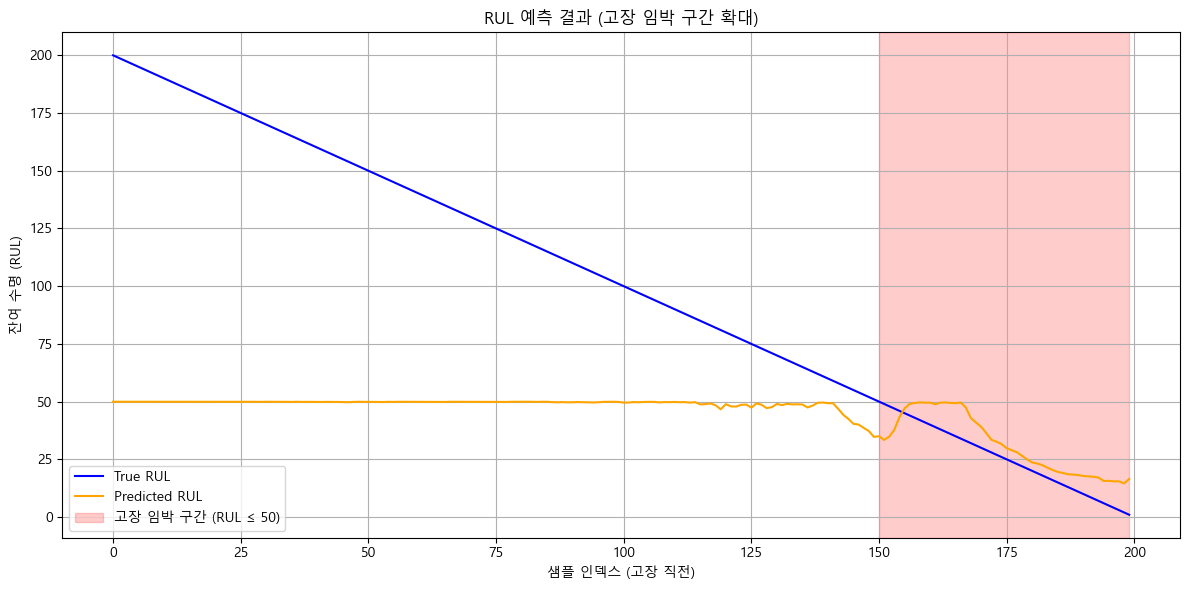

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# --- 설정 ---
window_size = 128
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
model_path = "phm_RUL_model_Huber.h5"
scaler_path = "scaler_sensor_all2.pkl"

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 불러오기 함수 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    return [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]

def extract_feature_rms(data_list):
    target_cols = data_list[0].shape[1]
    filtered = [df for df in data_list if df.shape[1] == target_cols]
    return np.array([np.sqrt((df**2).mean()).values for df in filtered])

def make_window_dataset(data, window_size):
    X, y = [], []
    total = len(data)
    for i in range(total - window_size):
        X.append(data[i:i+window_size])
        rul = total - (i + window_size)
        y.append(rul)
    return np.array(X), np.array(y)

# --- 데이터 전처리 ---
test_raw = load_bearing_data(test_dir)
X_test_all = extract_feature_rms(test_raw)
scaler = joblib.load(scaler_path)
X_test_all = scaler.transform(X_test_all)
X_test, y_test = make_window_dataset(X_test_all, window_size)

# --- 모델 불러오기 및 예측 ---
model = load_model(model_path)
y_pred = model.predict(X_test).flatten()

# --- 고장 임박 구간 설정 ---
focus_range = 200  # 마지막 200개 구간만 표시
start_idx = len(y_test) - focus_range
end_idx = len(y_test)

plt.figure(figsize=(12, 6))
plt.plot(range(focus_range), y_test[start_idx:end_idx], label="True RUL", color='blue')
plt.plot(range(focus_range), y_pred[start_idx:end_idx], label="Predicted RUL", color='orange')

# RUL 임계값 이하인 영역 시각화
threshold = 50
rul_array = y_test[start_idx:end_idx]
danger_idx = np.where(rul_array <= threshold)[0]
if len(danger_idx) > 0:
    plt.axvspan(danger_idx[0], danger_idx[-1], color='red', alpha=0.2, label=f'고장 임박 구간 (RUL ≤ {threshold})')

plt.xlabel("샘플 인덱스 (고장 직전)")
plt.ylabel("잔여 수명 (RUL)")
plt.title("RUL 예측 결과 (고장 임박 구간 확대)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

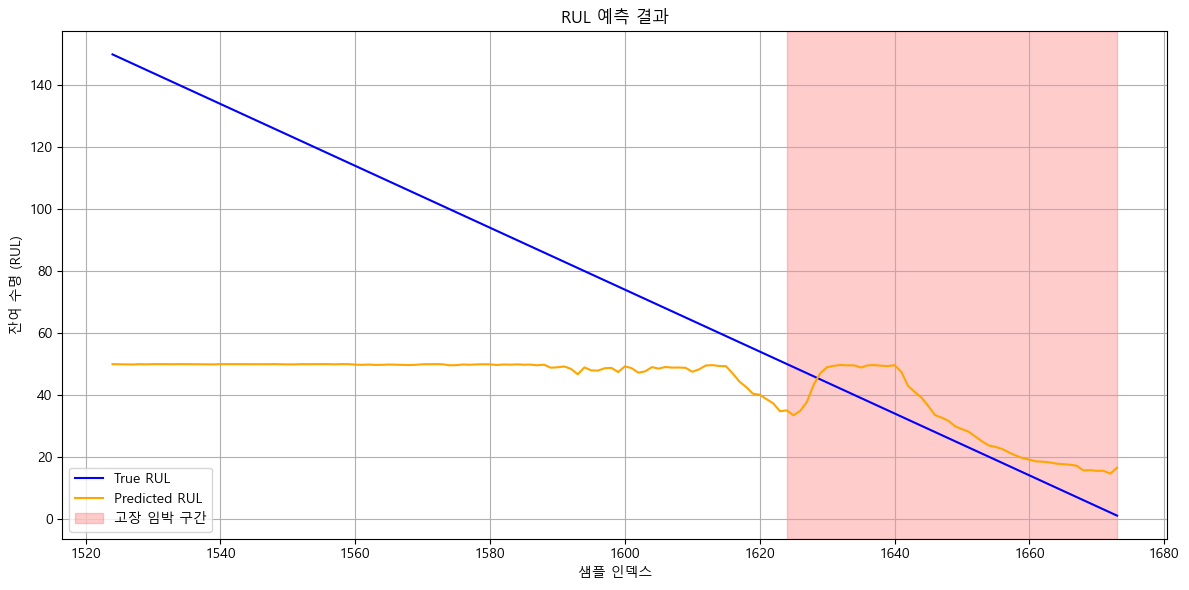

In [ ]:
# --- 빨간 구간 기준으로 시각화 범위 재설정 ---
def make_window_dataset(data, window_size):
    X, y = [], []
    total = len(data)
    for i in range(total - window_size):
        X.append(data[i:i+window_size])
        rul = total - (i + window_size)
        y.append(rul)  # ← 클리핑 없이 원래 RUL 그대로 사용
    return np.array(X), np.array(y)

threshold = 50
rul_array = y_test
danger_idx = np.where(rul_array <= threshold)[0]

if len(danger_idx) > 0:
    # 고장 임박 구간 시작점 기준으로 좌우로 100개 확장해서 보기
    left = max(danger_idx[0] - 100, 0)
    right = min(danger_idx[-1] + 50, len(rul_array))
else:
    left = len(rul_array) - 200
    right = len(rul_array)

# --- 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(range(left, right), y_test[left:right], label="True RUL", color='blue')
plt.plot(range(left, right), y_pred[left:right], label="Predicted RUL", color='orange')

# 빨간 박스
if len(danger_idx) > 0:
    plt.axvspan(danger_idx[0], danger_idx[-1], color='red', alpha=0.2, label=f'고장 임박 구간')

plt.xlabel("샘플 인덱스")
plt.ylabel("잔여 수명 (RUL)")
plt.title("RUL 예측 결과")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

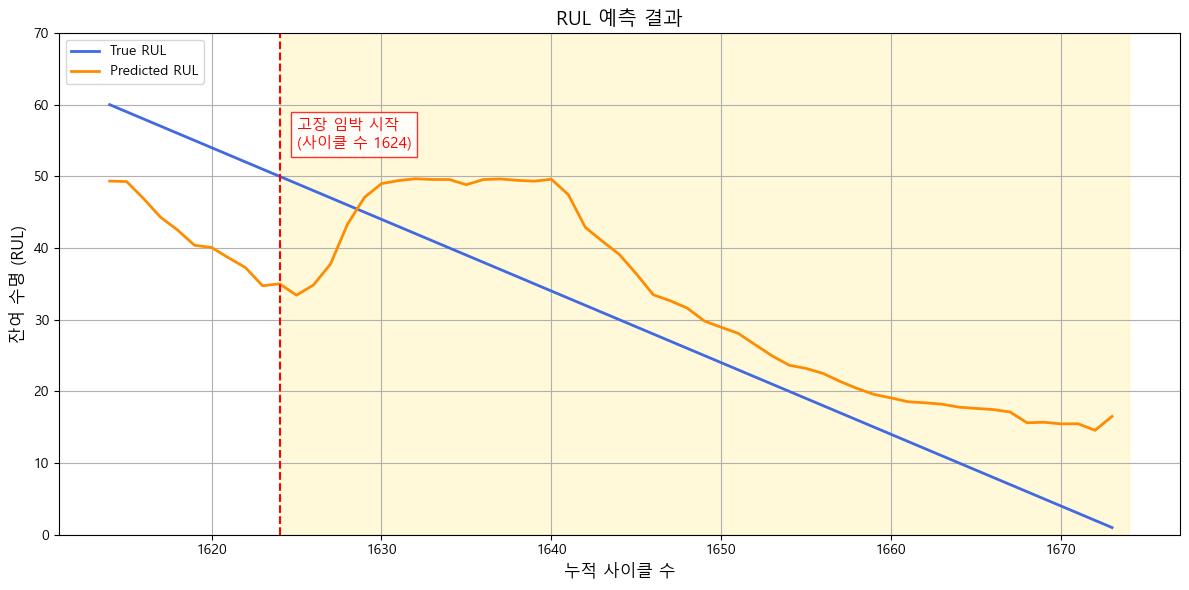

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(range(start, end), y_test[start:end], label="True RUL", color='royalblue', linewidth=2)
plt.plot(range(start, end), y_pred[start:end], label="Predicted RUL", color='darkorange', linewidth=2)

# 고장 임박 시점 강조 (x축 기준)
plt.axvspan(danger_indices[0], end, color='gold', alpha=0.15)
plt.axvline(danger_indices[0], color='red', linestyle='--', linewidth=1.5)

# 주석 텍스트 추가 (index → 사이클 수)
plt.text(danger_indices[0] + 1, max_rul * 0.9,
         f"고장 임박 시작\n(사이클 수 {danger_indices[0]})",
         color='red', fontsize=11,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

# 라벨/제목
plt.xlabel("누적 사이클 수", fontsize=12)
plt.ylabel("잔여 수명 (RUL)", fontsize=12)
plt.title("RUL 예측 결과", fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0, max_rul + 10)
plt.tight_layout()
plt.show()


# 최종 모델

정규화 scaler 저장 완료
Train X: (2675, 128, 6)
Train y: (2675,)
Epoch 1/50
168/168 [==============================] - 32s 175ms/step - loss: 20.2153 - mae: 20.6609 - val_loss: 0.7402 - val_mae: 0.9569
Epoch 2/50
168/168 [==============================] - 28s 169ms/step - loss: 0.4510 - mae: 0.4970 - val_loss: 0.7192 - val_mae: 0.7831
Epoch 3/50
168/168 [==============================] - 28s 167ms/step - loss: 0.4503 - mae: 0.4920 - val_loss: 0.7186 - val_mae: 0.7739
Epoch 4/50
168/168 [==============================] - 28s 166ms/step - loss: 0.4499 - mae: 0.4874 - val_loss: 0.7185 - val_mae: 0.7554
Epoch 5/50
168/168 [==============================] - 29s 172ms/step - loss: 0.4496 - mae: 0.4848 - val_loss: 0.7180 - val_mae: 0.7502
Epoch 6/50
168/168 [==============================] - 28s 167ms/step - loss: 0.4495 - mae: 0.4867 - val_loss: 0.7174 - val_mae: 0.7735
Epoch 7/50
168/168 [==============================] - 29s 172ms/step - loss: 0.4493 - mae: 0.4855 - val_loss: 0.7175 - val_mae: 0.

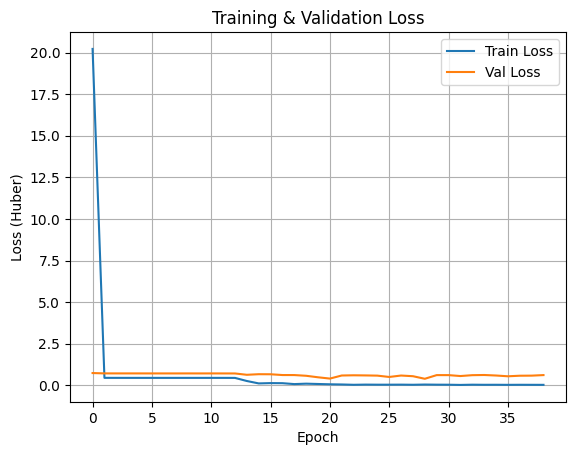

53/53 [==============================] - 6s 97ms/step

 성능 평가 결과:
MAE : 0.4818
RMSE: 2.3202
R²   : 0.7720
모델 저장 완료: phm_RUL_model_Huber4.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# cnn+lstm  + 노이즈 추가
# Huber Loss + 단층 LSTM 
# RUL은 작은 오차보다 큰 오차에 민감 → Huber Loss 등도 고려
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
import importlib
import noise_input
importlib.reload(noise_input)
from noise_input import RealisticNoiseInjector
# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

#노이즈 추가(noise_input.py)
def extract_feature_rms_with_noise(data_list, snr_db=30):
    injector = RealisticNoiseInjector(snr_db=snr_db, vibration_amp=0.05, apply_ratio=0.3, seed=42)
    noisy_rms = []
    for df in data_list:
        noisy_df = df.copy()
        for col in noisy_df.columns:
            signal = noisy_df[col].values
            signal = injector.inject(signal)  
            noisy_df[col] = signal
        rms = np.sqrt((noisy_df ** 2).mean()).values
        noisy_rms.append(rms)
    return np.array(noisy_rms)


# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

# --- RMS 특징 추출 with 노이즈 ---
X_train_all = extract_feature_rms_with_noise(train_raw, snr_db=15)
X_test_all  = extract_feature_rms(test_raw)


# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)
joblib.dump(scaler, "scaler_sensor_all5.pkl")
print("정규화 scaler 저장 완료")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 (단층 + Huber) ---
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 예측 및 성능 평가 ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n 성능 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 모델 저장 
model.save("phm_RUL_model_Huber4.h5")
print("모델 저장 완료: phm_RUL_model_Huber4.h5")
# RMS로 압축된 센서 시계열 데이터에 대해, CNN 레이어를 통해 시간축 국소 패턴(진폭 변화, 고장 전 진동 변화 등)을 먼저 감지한 뒤, 
# LSTM 레이어에서 이러한 패턴의 순차적 변화 흐름을 학습하여 잔여 수명을 예측하였습니다.

53/53 [==============================] - 5s 81ms/step


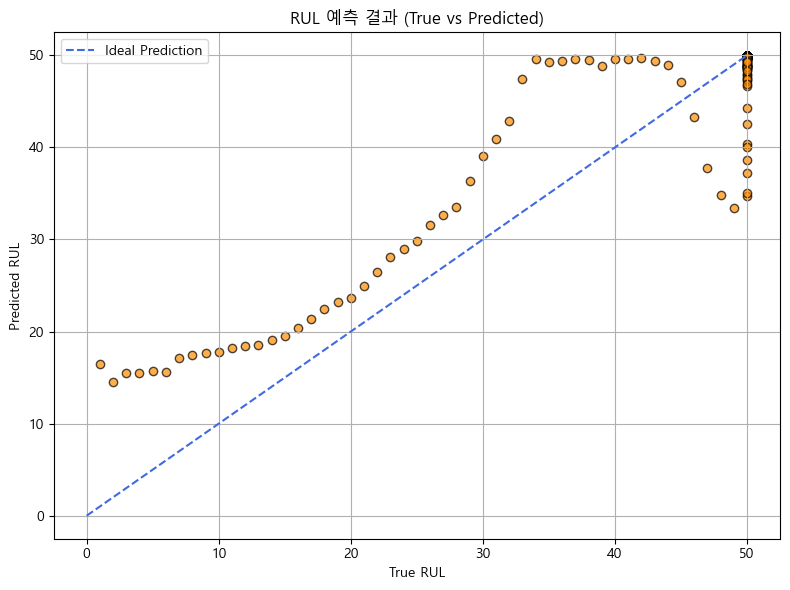

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 설정 ---
model_path = "phm_RUL_model_Huber4.h5"
scaler_path = "scaler_sensor_all5.pkl"
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    import os
    import pandas as pd
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    return [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]

test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
test_raw = load_bearing_data(test_dir)

def extract_feature_rms(data_list):
    return np.array([np.sqrt((df**2).mean()).values for df in data_list])  # (시점 수, 센서 수)

X_test_all = extract_feature_rms(test_raw)
scaler = joblib.load(scaler_path)
X_test_all = scaler.transform(X_test_all)

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_test, y_test = make_window_dataset(X_test_all, window_size, MAX_RUL)

# --- 모델 불러오기 및 예측 ---
model = load_model(model_path)
y_pred = model.predict(X_test).flatten()

# --- 산점도 시각화 ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='darkorange', alpha=0.7, edgecolors='k')
plt.plot([0, MAX_RUL], [0, MAX_RUL], color='royalblue', linestyle='--', label='Ideal Prediction')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL 예측 결과 (True vs Predicted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

고장 임박 구간 (x=0~10 근처):

예측값이 실제보다 높게 나오는 경우가 많음 → 잔여 수명을 과대평가
→ 고장을 너무 늦게 예측할 위험 있음 (리스크 ↑)

중간 구간 (x=10~40):

점들이 비교적 이상적 선(y=x)을 따라 분포
→ 모델이 이 구간에서는 비교적 정확하게 예측

최대값 클리핑 구간 (x=50):

True RUL=50에서 예측값이 다양하게 퍼져 있음
→ 이는 클리핑된 최대 RUL 값 때문에 발생.
→ 실제로는 더 높은 수명이었지만, 학습 데이터 상 한계가 있어 그 이상은 학습하지 못함

In [ ]:
이 그래프는 실제 RUL과 모델의 예측값을 비교한 산점도입니다. 중간 구간에서는 예측이 비교적 정확하나, 
고장 직전 구간에서는 예측이 다소 높게 나오는 경향이 있으며, 최대값 클리핑 구간에서는 예측값이 분산되어 있음을 확인할 수 있습니다. 
이는 고장 임박 시 모델의 보수적 대응이 필요함을 시사하며, 실제 유지보수 현장에서는 조기경보 기준 설정이 중요합니다.

In [ ]:
# rms는 수직가속도랑, 수평가속도에만 적용하도록 수정

정규화 scaler 저장 완료
Train X: (2675, 128, 2)
Train y: (2675,)


Epoch 1/50


168/168 [==============================] - 104s 593ms/step - loss: 17.3075 - mae: 17.7104 - val_loss: 0.7252 - val_mae: 0.8616
Epoch 2/50
168/168 [==============================] - 98s 582ms/step - loss: 0.4523 - mae: 0.4944 - val_loss: 0.7202 - val_mae: 0.8067
Epoch 3/50
168/168 [==============================] - 89s 529ms/step - loss: 0.4514 - mae: 0.4889 - val_loss: 0.7198 - val_mae: 0.8137
Epoch 4/50
168/168 [==============================] - 92s 545ms/step - loss: 0.4513 - mae: 0.4947 - val_loss: 0.7184 - val_mae: 0.8026
Epoch 5/50
168/168 [==============================] - 95s 564ms/step - loss: 0.4503 - mae: 0.4913 - val_loss: 0.7169 - val_mae: 0.7677
Epoch 6/50
168/168 [==============================] - 95s 565ms/step - loss: 0.4501 - mae: 0.4932 - val_loss: 0.7166 - val_mae: 0.7837
Epoch 7/50
168/168 [==============================] - 91s 542ms/step - loss: 0.4490 - mae: 0.4907 - val_loss: 0.7163 - val_ma

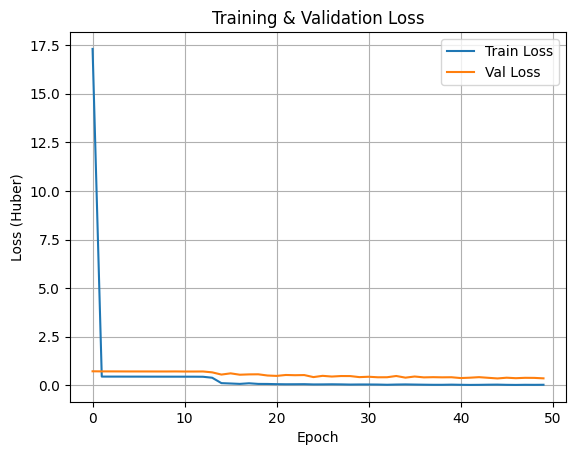

53/53 [==============================] - 19s 352ms/step

 성능 평가 결과:
MAE : 0.3966
RMSE: 2.0294
R²   : 0.8256
모델 저장 완료: phm_RUL_model_Huber5.h5


c:\Users\enjoy\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
# cnn+lstm  + 노이즈 추가
# Huber Loss + 단층 LSTM 
# RUL은 작은 오차보다 큰 오차에 민감 → Huber Loss 등도 고려
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

import importlib
import noise_input
importlib.reload(noise_input)
from noise_input import RealisticNoiseInjector


# --- 경로 설정 ---
train_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Learning_set/Bearing1_1"
test_dir = r"C:/Users/enjoy/Downloads/phm-ieee-2012-data-challenge-dataset-master/phm-ieee-2012-data-challenge-dataset-master/Test_set/Bearing1_3"
window_size = 128
MAX_RUL = 50

# --- 데이터 불러오기 ---
def load_bearing_data(folder_path):
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    data_list = [pd.read_csv(os.path.join(folder_path, f), header=None) for f in file_list]
    return data_list

train_raw = load_bearing_data(train_dir)
test_raw = load_bearing_data(test_dir)

#노이즈 추가(noise_input.py)
def extract_feature_rms_with_noise(data_list, snr_db=30):
    injector = RealisticNoiseInjector(snr_db=snr_db, vibration_amp=0.05, apply_ratio=0.3, seed=42)
    noisy_rms = []
    for df in data_list:
        noisy_df = df.copy()
        for col in df.columns[4:6]:  # ✅ 센서 열만 노이즈 주입
            signal = noisy_df[col].values
            noisy_df[col] = injector.inject(signal)
        rms = np.sqrt((noisy_df.iloc[:, 4:6] ** 2).mean()).values  # ✅ 센서 열만 RMS 계산
        noisy_rms.append(rms)
    return np.array(noisy_rms)



# --- RMS 특징 추출 ---
def extract_feature_rms(data_list):
    return np.array([
        np.sqrt((df.iloc[:, 4:6] ** 2).mean()).values  # RMS 계산
        for df in data_list
    ])

# --- RMS 특징 추출 with 노이즈 ---
X_train_all = extract_feature_rms_with_noise(train_raw, snr_db=15)
X_test_all  = extract_feature_rms(test_raw)


# --- 정규화 ---
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all  = scaler.transform(X_test_all)
joblib.dump(scaler, "scaler_sensor_all6.pkl")
print("정규화 scaler 저장 완료")

# --- 윈도우 및 RUL 생성 ---
def make_window_dataset(data, window_size, max_rul=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        rul = len(data) - (i + window_size)
        y.append(min(rul, max_rul))
    return np.array(X), np.array(y)

X_train, y_train = make_window_dataset(X_train_all, window_size, MAX_RUL)
X_test, y_test   = make_window_dataset(X_test_all, window_size, MAX_RUL)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

# --- 모델 구성 (단층 + Huber) ---
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# --- 학습 ---
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- 학습 시각화 ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 예측 및 성능 평가 ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n 성능 평가 결과:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 모델 저장 
model.save("phm_RUL_model_Huber5.h5")
print("모델 저장 완료: phm_RUL_model_Huber5.h5")
# RMS로 압축된 센서 시계열 데이터에 대해, CNN 레이어를 통해 시간축 국소 패턴(진폭 변화, 고장 전 진동 변화 등)을 먼저 감지한 뒤, 
# LSTM 레이어에서 이러한 패턴의 순차적 변화 흐름을 학습하여 잔여 수명을 예측하였습니다.